A notebook for capturing calibration data for the cameras of the OROCHI Simualtor of the Kameda Lab.

Sixth round of experiments after procedure upgrade adding 8th camera, and switching some camera positions, and setting to switch from 30 FPS to 1 FPS for exposures longer than 500 ms.

Using a gain of 4.27 dB to raise apparent full well to 20000 e-, and sensitivity to 4.88 e-/DN.
Reducing Blacklevel to 8 DN from 128 DN, to increase sensitive range.

# Process Overview

The objective of this notebook is to process uniformly illuminated and dark images (across the sampling area) and characterise each camera of the OROCHI simulator, or OROS, in terms of:
- Read Noise
- Saturation Capacity
- Gain (Sensitivity)
- Linearity
- Dark Signal
- SNR
- FPN

The goal is to demonstrate that the performance of OROS is comparable to that expected of the OROCHI Flight Model.

For each of the SCT99 and SCT5 targets, we:
- for each channel:
    - load the list of exposures
    - for each exposure,
        - load image 1
        - load image 2
        - load the dark frame
        - get mean of image 1 - dark
        - get the noise of image 1 - dark
        - get the noise of image 1 - image 2
    - get the read noise
    - get shot noise
    - get sensitivity
    - get full well
    - evaluate linearity
    - plot mean vs exposure
    - plot temporal dark noise vs exposure
    - plot sensitivity vs mean
    - plot noise vs mean (PTC)
    - plot noise vs mean (electron PTC)
    - plot linearity vs mean
    - plot dark signal vs exposure
    - plot SNR vs mean
    - plot SNR vs exposure

For each of these, we will also plot the expected data, based on the datasheet of the OROCHI simulator (OROS), and the expected performance of the OROCHI Flight Model.

As we'd like to repeat this for each camera, we will write each of these steps into functions, contained in the notebook here, such that the analysis can be iterated and automated.

In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Expected Performance of OROS and OROCHI

## OROCHI Simulator (OROS)

The OROCHI Simulator cameras each use the Sony IMX249LLJ CMOS sensor, in the TIS (The Imaging Source) DMK 33GX249 camera unit https://www.theimagingsource.com/en-us/product/industrial/33g/dmk33gx249/.
This is a 2.35MP monochrome sensor, with 5.86µm pixel pitch.

The datasheet for the sensor does not offer detailled information, 
https://s1-dl.theimagingsource.com/api/2.5/packages/publication/sensor-sony/imx249llj/6a48775d-a298-532c-b1ec-5b4c0262b7c4/imx249llj_1.0.en_US.pdf
however 3rd parties do provide further characteristics:
https://www.baumer.com/medias/__secure__/EMVA_VCXG-24M_CID010002_External.pdf?mediaPK=9021140598814
https://www.framos.com/en/products/imx249llj-c-17041

The most detailed specifications are given by Baumer, recorded empirically using the EMVA1288 Standard method.

The revelant results are as follows:

Sense Node Gain: 26.5 µV/e- (850 mV saturation voltage from Sony Datasheet, implies 32075 e- saturation capacity) \
Overall system sensitivity: 7.979 e−/DN \
Temporal dark noise: 0.82 DN (6.13 e−) \
SNRmax: 179 (45.1 dB, 7.5 bit) \
Dynamic range: 4535 (73.1 dB, 12.1 bit) \
Nonlinearity: LE 0.37% (LEmin -0.41%, LEmax 0.32%) \
Read Noise: 7.07 e− \
Saturation Capacity: 32059 e− \
Dark Current: 8.8 e-/s @ ~32°C

Note this was collected with a Gain of 1.0 (i.e. 0.0 dB) and a blacklevel of 39 DN.

## OROCHI Flight Model

The OROCHI Flight Model cameras each use the On-Semiconductor KAI-08051 CCD Interline Transfer sensor.
The datasheet (https://www.mouser.com/datasheet/2/308/KAI-08051-D-599880.pdf) gives detailled information on the performance:

Sense Node Gain: 39 µV/e- \
Overall system sensitivity: 4.88 e-/DN (Full Well over Max DN for 12-bit mode, 1.22 e-/DN for 14-bit mode) \
Temporal dark noise: 0.82 DN (6.13 e−) \
SNRmax: 141.4 (43.0 dB, 7.1 bit) \
Dynamic range: 2000 (66 dB, 11 bit) \
Nonlinearity: LE 1%  \
Read Noise: 10 e− (2.05 DN, for 12-bit mode, 8.2 DN for 14-bit mode) \
Full Well: 20000 e− \
Dark Signal: ~2 e-/s

OROCHI will be operated in 14-bit mode. However, the effective dynamic range is 2000, equivalent to 11 bits. So we expect to be ablke to approximate OROCHI well with the maximum 12-bit operatiuon of OROS, and so comparisons here are drawn against OROCHI under the assumption of 12-bit operation.
Note also that the OROCHI sensor dark signal is expected to be as low as 7 e-/s at a reference temperature of 40°C, with a doubling coefficient of 7°C, hence at the reference temerapture of 30°C we expect very low dark signal contributions. Note also that this may be resolvable in OROCHI 14-bit mode, but would be harder to precisely measure in 12-bit mode.

# Comparison

## Full Well

The Full Well $n_{FW}$ of OROS is greater than OROCHI: 32049 vs 20000 electrons.
This has implications on the maximum achievable SNR (below).

## SNR-Max
The key impact of the Full Well is on the maximum possible SNR, approximated by:

${SNR}_{max} = n_{FW} / \sqrt{n_{FW}}$

where $\sqrt{n_{FW}}$ is the shot-noise at Full Well.
Hence we expect OROS to achieve a greater ${SNR}_{max}$ of 179 vs 141.

This performance increase would mean that OROS observations would overestimate the performance of OROCHI.
However, we can avoid this by ensuring the detection does not exceed 20000 electron Full Well of OROCHI.

## Sensitivity and System Gain

The overall system sensitivty of OROS is just more than half that of OROCHI, giving 7.979 e- for each DN, in comparison to 4.88 e-.
The implication is that each DN represents a different number of electrons for the two systems, so in the range of interest, the sensitivity of OROS is lower.

We can mitigate this by adjusting the gain settings of the OROS channels, by the following amount:

$20*\log(7.979/4.88) = 4.27$ dB

Applying this gain to OROS should achieve an equivalent sensitivity to OROCHI.
However, it will also increase the read noise, but it should not effect the shot noise, as this is introduce pre-gain.

It will, however, effect the max SNR achievable, as the full-well capacity will have been scaled to ~6567 DN, much greater than the 4096 DN maximum 12-bit value of OROS.

Conicidently, the apparent full-well (or *saturation capacity*) will now be approximately 20,000 electrons, matching that of OROCHI.

## Read Noise

The read noise sets the lower limit of detectability.
With a gain of 0 dB, the read noise of OROS was expected to be 7.07 e-, that would have equated to a DN rms level of 0.88 DN.
With a new sensitivity of 4.88 e-/DN, we can expect a read noise of 1.45 DN.
As we do not expect to analyse regions of the image in the read-limited regime of the detector, we do not expect this to be an issue.
However, if the read noise consists of signficant post-amplifier noise sources, then we will expect this value to be amplifed. We deduce if there is signifcant post-amplifier noise by comparing the observed read noise to the expectation value.

## Dynamic Range

With a gain of 0 dB, OROS had a dynamic range of 73.15 dB, requiring 4535 steps to represent, of which 4096 could be represented by the 12-bit detector.
With a gain of 4.27 dB, we expect the new dynamic range to be 69 dB, requiring 2829 steps to represent, of which we can represent 4096.
Note that this still exceeds that of OROCHI, which has 66 dB dynamic range, requiring 2000 steps.

## Linearity 

OROS has an expected linearity that is higher than OROCHI, with an expected error of <0.4 % in comparison to an expected error of 1%.
However, we still must verify if this holds over the complete detector range.
As we are applying gain, and thus operating the sense-node far below the saturation region, we expect to attain high linearity for all values.

## Note

We are predominantly concerned with ensuring all pixels exceed a certin electron count, such that a minimum exposed SNR of 100 is achieved in all channels.
At the new gain settings, we expect to achieve an SNR of 100, requring 10000 electrons, at a level of 2049 DN.
We will evaluate empirically the true SNR 100 threshold, in terms of electron count and DN level to verify this.

We have found that adjusting the blacklevel of the camera does not apply an offset voltage, but rather just changes the lowest allowed DN value in an image. This doe snot help resolve or avoid underflow. We assume that the camera has been set up with sufficient fixed offset that allows for characterisation of dark and bias frames.

# PCT99

Here we process the PTC (Photon Transfer Curve) data for each channel in turn.


In [67]:
colours = plt.get_cmap("tab10")

In [49]:
from pathlib import Path
import orochi_sim_proc as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def process_ptc(subject, dark):
    channels = sorted(list(Path('..', 'data', subject).glob('[!.]*')))

    # gain
    g = 10.0**(4.3 / 20)

    # full well
    fw_exp_os = 32049.0 # expected full well (e-) for OROS
    fw_exp_os_g = fw_exp_os / g # expected full well (e-) for OROS with gain
    fw_exp_of = 20000.0 # expected full well (e-) for OROCHI
    # read noise
    rn_exp_os = 7.07 # expected read noise (e-) for Oro-S
    rn_exp_os_g = rn_exp_os # expected read noise (e-) for Oro-S with gain
    rn_exp_of = 10.0 # expected read noise (e-) for OROCHI
    # sensitivity
    k_exp_os = 7.979 # expected sensitivity in 12-bit mode for Oro-S - Baumer EMVA Study
    k_exp_os_g = k_exp_os / g # expected sensitivity in 12-bit mode for Oro-S with gain
    k_exp_of = fw_exp_of / 2**12 # expected sensitivity in 12-bit mode for OROCHI
    # read noise
    rn_dn_exp_os = rn_exp_os / k_exp_os # expected read noise (DN) for OROS
    rn_dn_exp_os_g = rn_dn_exp_os * g # expected read noise (DN) for OROS with gain
    rn_dn_exp_of = rn_exp_of / k_exp_of # expected read noise (DN) for OROCHI
    # SNR
    snr_exp_os = fw_exp_os / np.sqrt(fw_exp_os) # expected peak SNR for OROS
    snr_exp_os_g = fw_exp_os_g / np.sqrt(fw_exp_os_g) # expected peak SNR for OROS
    snr_exp_of = fw_exp_of / np.sqrt(fw_exp_of) # expected peak SNR for OROCHI
    snr_min = 100 # minimum acceptable SNR
    # Dynamic Range
    dr_exp_os = 20.0*np.log10(fw_exp_os/rn_exp_os)
    dr_exp_os_g = 20.0*np.log10(fw_exp_os_g/rn_exp_os_g)
    dr_exp_of = 20.0*np.log10(fw_exp_of/rn_exp_of)
    # dark current (e-/s) at ~30°C
    dc_exp_os = 8.8
    dc_exp_os_g = 8.8
    dc_exp_of = 2.6

    # expected response for each channel of OROCHI at Mars:
    response_exp_of = {
        400:   33909.120210,
        475:   34660.711142,
        550:  34660.683017,
        650:   31148.687877,
        725:   19333.888021,
        850:   6106.064279,
        950:   3166.538335
    }

    fig_exp, ax_exp = osp.grid_plot() # init the exposure grid plot
    cntr_exp = ax_exp[8] # centre plot for overlaying the exposures

    fig_lin, ax_lin = osp.grid_plot() # init the linearity plot
    cntr_lin = ax_lin[8] # centre plot for overlaying the linearity
    lin_min = 0
    lin_max = 2**12
    
    fig_var_dn, ax_var_dn = osp.grid_plot() # init the dark variance DN plot
    cntr_var_dn = ax_var_dn[8] # centre plot for overlaying the dark varianct DN
    var_dn_min = 1E-5
    var_dn_max = 100
    
    fig_kadc, ax_kadc = osp.grid_plot() # init the K ADC plot
    cntr_kadc = ax_kadc[8] # centre plot for overlaying the K ADC
    kadc_min = 0
    kadc_max = 2**12

    fig_ptc_dn, ax_ptc_dn = osp.grid_plot() # init the ptc DN plot
    cntr_ptc_dn = ax_ptc_dn[8] # centre plot for overlaying the PTC DN
    ptc_dn_min = 1E-1
    ptc_dn_max = 2**13
    
    fig_ptc, ax_ptc = osp.grid_plot() # init the ptc grid plot
    cntr_ptc = ax_ptc[8] # centre plot for overlaying the PTC
    ptc_e_min = 1E0
    ptc_e_max = 1E5

    fig_d_exp, ax_d_exp = osp.grid_plot() # init the dark signal plot
    cntr_d_exp = ax_d_exp[8] # centre plot for overlaying the dark signal
    d_exp_min = 0.0
    d_exp_max = 60

    

    # fig_dsnu_exp, ax_dsnu_exp = osp.grid_plot() # init the DSNU plot
    # cntr_dsnu_exp = ax_dsnu_exp[8] # centre plot for overlaying the DSNU

    fig_snr, ax_snr = osp.grid_plot() # init the SNR plot
    cntr_snr = ax_snr[8] # centre plot for overlaying the SNR
    snr_dn_min = 0
    snr_dn_max = 2**12

    fig_snr_exp, ax_snr_exp = osp.grid_plot() # init the SNR plot
    cntr_snr_exp = ax_snr_exp[8] # centre plot for overlaying the SNR

    cameras = ['OROS-OTS', 'OROS', 'OROCHI']
    k_adcs = [k_exp_os, k_exp_os_g, k_exp_of]
    full_wells = [fw_exp_os, fw_exp_os_g, fw_exp_of]
    read_noises = [rn_exp_os, rn_exp_os_g, rn_exp_of]
    dark_currents = [dc_exp_os, dc_exp_os_g, dc_exp_of]
    drs = [dr_exp_os, dr_exp_os_g, dr_exp_of]
    lin_mins = [-0.41, -0.41, 0.0]
    lin_maxs = [0.32, 0.32, 0.0]
    t_exp_mins = [0,0,0]
    t_exp_maxs = [0,0,0]
    expected_responses = [0,0,0]
    responses = [0,0,0]

    # colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colours = plt.get_cmap("tab10")

    for channel_path in channels:
        channel = channel_path.name        
        print('--------------------------------------------')
        print(f'Processing {subject}/{channel}')
        # load the calibration target images, and compute the full well, linear sensitivity and read noise
        dtc_data, read_noise, dark_current = osp.load_dtc_frames(dark, channel)
        pct_data, full_well, k_adc, read_noise, lin_min, lin_max, offset, response = osp.load_ptc_frames(subject, channel, read_noise=read_noise)

        # pct_data.sort_values('exposure', inplace=True)
        num = int(channel.split('_')[0]) # get camera number
        wvl = int(channel.split('_')[1]) # get camera wavelength        
        chnl_str = f'Camera {num}: {wvl} nm' # create channel string
        
        colour = colours(num) # get colour for channel

        # plot Mean vs Exposure
        pct_data.plot.scatter('exposure', 'mean', title=chnl_str, color=colour, ax=ax_exp[num]) #, logx=True, logy=True)
        pct_data.plot.scatter('exposure', 'mean', title='All Channels', color=colour, ax=cntr_exp) #, logx=True, logy=True)
        # fitted values
        ax_exp[num].plot(pct_data['exposure'], pct_data['exposure']*response + offset, linestyle='solid', color=colour, label='Fit')
        cntr_exp.plot(pct_data['exposure'], pct_data['exposure']*response + offset, linestyle='solid', color=colour, label='Fit')
        # expected response of OROCHI
        ax_exp[num].plot(pct_data['exposure'], pct_data['exposure']*response_exp_of[wvl], linestyle='solid', color='k', label='OROCHI')
        cntr_exp.plot(pct_data['exposure'], pct_data['exposure']*response_exp_of[wvl], linestyle='dashdot', color=colour, label='OROCHI')  
        ax_exp[num].set_yscale('log')
        ax_exp[num].set_xscale('log')
        ax_exp[num].set_ylabel('Mean (DN)')
        ax_exp[num].set_xlabel('Exposure (s)')
        cntr_exp.set_ylabel('Mean (DN)')
        cntr_exp.set_xlabel('Exposure (s)')
        ax_exp[num].set_ylim(0,2**12)
        cntr_exp.set_ylim(0,2**12)

        # plot temporal dark variance against Exposure
        # data
        ax_var_dn[num].loglog(dtc_data['exposure'], dtc_data['std_rs'], '.', label=chnl_str, color=colour)            
        cntr_var_dn.loglog(dtc_data['exposure'], dtc_data['std_rs'], '.', label='All Channels', color=colour)            
        # fit
        ax_var_dn[num].axhline(read_noise, linestyle='solid', color=colour, label='Fit')
        cntr_var_dn.axhline(read_noise, linestyle='solid', color=colour, label='Fit')        
        fit_std_rs = np.sqrt(read_noise**2 + (dark_current * dtc_data['exposure'] / k_adc))
        ax_var_dn[num].loglog(dtc_data['exposure'], fit_std_rs, linestyle='solid', color=colour, label='Fit')
        cntr_var_dn.loglog(dtc_data['exposure'], fit_std_rs, linestyle='solid', color=colour, label='Fit')
        # expected
        oros_g_exp_std_rs = np.sqrt(rn_dn_exp_os_g**2 + (dc_exp_os_g * dtc_data['exposure'] / k_exp_os_g))        
        oros_exp_std_rs = np.sqrt(rn_dn_exp_os**2 + (dc_exp_os * dtc_data['exposure'] / k_exp_os))
        of_exp_std_rs = np.sqrt(rn_dn_exp_of**2 + (dc_exp_of * dtc_data['exposure'] / k_exp_of))        
        ax_var_dn[num].axhline(rn_dn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
        ax_var_dn[num].loglog(dtc_data['exposure'], oros_g_exp_std_rs, linestyle='dashed', color='k', label='OROS (g)')
        # labels
        ax_var_dn[num].set_title(chnl_str)
        ax_var_dn[num].set_ylabel('Temporal Dark Noise (DN)')
        ax_var_dn[num].set_xlabel('Exposure (s)')

        # plot Noise (Total, FPN-removed, Shot) vs Mean and FW and Read Noise and expectations
        # data
        pct_data.plot('mean', ['std_t','std_rs', 'std_s'], style=['.','x', '+'], logx=True, logy=True, color=colour, title=chnl_str, ax=ax_ptc_dn[num] ,legend=False)
        pct_data.plot('mean', ['std_t','std_rs', 'std_s'], style=['.','x', '+'], logx=True, logy=True, color=colour, title='All Channels', ax=cntr_ptc_dn, legend=False)
        # fitted read noise                        
        ax_ptc_dn[num].axhline(read_noise, linestyle='solid', color=colour, label='RN')                
        cntr_ptc_dn.axhline(read_noise, linestyle='solid', color=colour, label='RN')        
        # expected read noise
        ax_ptc_dn[num].axhline(rn_dn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
        # fitted full well        
        ax_ptc_dn[num].axvline(full_well, linestyle='solid', color=colour, label='FW')        
        cntr_ptc_dn.axvline(full_well, linestyle='solid', color=colour, label='FW')
        # expected full well
        ax_ptc_dn[num].axvline((fw_exp_os_g/k_exp_os_g), linestyle='dashed', color='k', label='OROS (g)')        
        # fitted gain
        ax_ptc_dn[num].plot(pct_data['mean'], np.sqrt(pct_data['mean']/k_adc), linestyle='solid', color=colour, label='$K_{ADC}$')
        ax_ptc_dn[num].plot(pct_data['mean'], np.sqrt(pct_data['mean']/k_exp_os_g), linestyle='dashed', color='k', label='OROS (g)')
        ptc_dn_min, ptc_dn_max = ax_ptc_dn[num].get_xlim()
        cntr_ptc_dn.plot([ptc_dn_min, ptc_dn_max], np.sqrt(np.array([ptc_dn_min, ptc_dn_max])/k_adc), linestyle='solid', color=colour, label='$K_{ADC}$ Expected')
        # expected gain
        # ax_ptc_dn[num].legend()
        ax_ptc_dn[num].set_ylabel('Noise (DN)')
        ax_ptc_dn[num].set_xlabel('Mean Signal (DN)')
        cntr_ptc_dn.set_ylabel('Noise (DN)')
        cntr_ptc_dn.set_xlabel('Mean Signal (DN)')

        # plot sensitivity for all channels
        # data
        ax_kadc[num].plot(pct_data['mean'], pct_data['k_adc'], '.', label=chnl_str, color=colour)            
        cntr_kadc.plot(pct_data['mean'], pct_data['k_adc'], '.', label='All Channels', color=colour)            
        ax_kadc[num].set_ylim(0, 2.0 * k_exp_of)        
        cntr_kadc.set_ylim(0, 2.0 * k_exp_of)        
        ax_kadc[num].set_title(chnl_str)
        cntr_kadc.set_title('All Channels')
        # fitted sensitivity
        ax_kadc[num].plot(pct_data['mean'], k_adc+(0.0*pct_data['mean']), color=colour)  # overplot the mean k_adc for the channel 
        ax_kadc[num].plot(pct_data['mean'], k_exp_os_g+(0.0*pct_data['mean']), color='k', linestyle='dashed',label='OROS (g)') # overplot expectation
        cntr_kadc.plot(pct_data['mean'], k_adc+(0.0*pct_data['mean']), color=colour)  # overplot the mean k_adc for the channel 

        ax_kadc[num].set_ylabel('Sensitivity (e-/DN)')
        ax_kadc[num].set_xlabel('Mean Signal (DN)')
        cntr_kadc.set_ylabel('Sensitivity (e-/DN)')
        cntr_kadc.set_xlabel('Mean Signal (s)')

        # plot linearity for all channels
        # data
        ax_lin[num].plot(pct_data['exposure'], pct_data['linearity'], linestyle='dotted', marker='o', label=chnl_str, color=colour)            
        cntr_lin.plot(pct_data['mean'], pct_data['linearity'], linestyle='dotted', marker='o',label='All Channels', color=colour)    
        ax_lin[num].set_ylabel('Linearity (%)')
        ax_lin[num].set_xlabel('Exposure (s)')
        cntr_lin.axhline(lin_min, linestyle='solid', color=colour, label='Min') # overplot expectation
        cntr_lin.axhline(lin_max, linestyle='solid', color=colour, label='Max') # overplot expectation
        cntr_lin.set_ylabel('Linearity (%)')
        cntr_lin.set_xlabel('Mean Signal (DN)')
        ax_lin[num].set_ylim(lin_min,lin_max)
        ax_lin[num].set_title(chnl_str)
        cntr_lin.set_title('All Channels')

        # plot Electron Signal and Noise        
        pct_data.plot.scatter('e-','e-_noise', logx=True, logy=True, marker='+', title=chnl_str, color=colour, ax=ax_ptc[num], legend=False)
        pct_data.plot.scatter('e-','e-_noise', logx=True, logy=True, marker='+', title='All Channels', color=colour, ax=cntr_ptc, legend=False)
        # fitted read noise        
        ax_ptc[num].axhline(k_adc*read_noise, linestyle='solid', color=colour, label='RN')        
        ax_ptc[num].axhline(rn_dn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')        
        cntr_ptc.axhline(k_adc*read_noise, linestyle='solid', color=colour, label='RN')
        # fitted full well        
        ax_ptc[num].axvline(full_well*k_adc, linestyle='solid', color=colour, label='FW')        
        ax_ptc[num].axvline(fw_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')        
        cntr_ptc.axvline(full_well*k_adc, linestyle='solid', color=colour, label='FW')
        # expected shot response
        ax_ptc[num].plot(pct_data['e-'], np.sqrt(pct_data['e-']), linestyle='solid', color=colour, label='Shot Limit')
        ax_ptc[num].plot(pct_data['e-'], np.sqrt(pct_data['e-']), linestyle='dashed', color='k', label='OROS (g)')
        cntr_ptc.plot(pct_data['e-'], np.sqrt(pct_data['e-']), linestyle='solid', color=colour, label='Shot Limit')
        ax_ptc[num].set_ylabel('Noise (e-)')
        ax_ptc[num].set_xlabel('Mean Signal (e-)')
        cntr_ptc.set_ylabel('Noise (e-)')
        cntr_ptc.set_xlabel('Mean Signal (e-)')

        # plot Dark Signal vs Exposure
        ax_d_exp[num].plot(dtc_data['exposure'], dtc_data['mean'], '.', label=chnl_str, color=colour)            
        cntr_d_exp.plot(dtc_data['exposure'], dtc_data['mean'], '.', label='All Channels', color=colour)            
        ax_d_exp[num].set_title(chnl_str)
        cntr_d_exp.set_title('All Channels')
        exp_dark = dark_current * dtc_data['exposure']
        ax_d_exp[num].plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')                
        cntr_d_exp.plot(dtc_data['exposure'], exp_dark, linestyle='solid', color=colour, label='exp')
        ax_d_exp[num].plot(dtc_data['exposure'], (dc_exp_os_g/k_exp_os_g)*dtc_data['exposure'], linestyle='dashed', color='k', label='OROS (g)')
        ax_d_exp[num].set_ylabel('Dark Signal (DN)')
        ax_d_exp[num].set_xlabel('Exposure (s)')
        cntr_d_exp.set_ylabel('Dark Signal (DN)')
        cntr_d_exp.set_xlabel('Exposure (s)')
    

        # plot SNR vs Mean for all channels
        pct_data.plot('mean',['snr', 'snr_t'], ylim=(0, 200), style=['+', '.'], color=colour, ax=ax_snr[num], title=chnl_str, legend=False)    
        ax_snr[num].plot(pct_data['mean'], np.sqrt(k_adc*pct_data['mean']), linestyle='solid', color=colour, label='SNR-fit')
        pct_data.plot('mean',['snr', 'snr_t'], ylim=(0, 200), style=['+', '.'], color=colour, ax=cntr_snr, title='All Channels', legend=False)         
        ax_snr[num].set_ylabel('SNR')
        ax_snr[num].set_xlabel('Mean Signal (DN)')
        cntr_snr.set_ylabel('SNR')
        cntr_snr.set_xlabel('Mean Signal (DN)')

        # SNR max
        snr_max = np.sqrt(full_well*k_adc)
        snr_min = 100.0
        ax_snr[num].plot(pct_data['mean'], snr_max+(0.0*pct_data['mean']), color=colour, linestyle='solid', label='SNR-max')        
        ax_snr[num].plot(pct_data['mean'], snr_min+(0.0*pct_data['mean']), color=colour, linestyle='solid', label='Min. accept.')
        ax_snr[num].plot(pct_data['mean'], snr_exp_os_g+(0.0*pct_data['mean']), color='k', linestyle='dashed', label='OROS (g)')

        # shade acceptable DN range
        dn_min = (snr_min**2)/k_adc
        dn_max = (snr_max**2)/k_adc
        ax_snr[num].fill_betweenx([0,200], dn_min, dn_max, color=colour, alpha=0.1)
        cntr_snr.fill_betweenx([0,200], dn_min, dn_max, color=colour, alpha=0.1)

        cntr_snr.plot(pct_data['mean'], np.sqrt(full_well*k_adc)+(0.0*pct_data['mean']), color=colour, linestyle='solid', label='SNR-max')        


        # plot SNR vs Exposure for all channels
        pct_data.plot('exposure',['snr', 'snr_t'], ylim=(0, 200), style=['+', '.'], color=colour, ax=ax_snr_exp[num], title=chnl_str, legend=False)    
        ax_snr_exp[num].plot(pct_data['exposure'], np.sqrt(k_adc*pct_data['mean']), color=colour, linestyle='solid', label='SNR-fit')
        pct_data.plot('exposure',['snr', 'snr_t'], ylim=(0, 200), style=['+', '.'], color=colour, ax=cntr_snr_exp, title='All Channels', legend=False)         
        ax_snr_exp[num].set_ylabel('SNR')
        ax_snr_exp[num].set_xlabel('Exposure (s)')
        cntr_snr_exp.set_ylabel('SNR')
        cntr_snr_exp.set_xlabel('Exposure (s)')

        # SNR max
        snr_max = np.sqrt(full_well*k_adc)
        snr_min = 100.0
        ax_snr_exp[num].plot(pct_data['exposure'], snr_max+(0.0*pct_data['exposure']), color=colour, linestyle='solid', label='SNR-max')        
        ax_snr_exp[num].plot(pct_data['exposure'], snr_min+(0.0*pct_data['exposure']), color=colour, linestyle='solid', label='Min. accept.')
        ax_snr_exp[num].plot(pct_data['exposure'], snr_exp_os_g+(0.0*pct_data['mean']), color='k', linestyle='dashed', label='OROS (g)')

        # # shade acceptable DN range
        # fit exposure - mean DN in linear range
        range = (pct_data['mean'] < full_well*0.9) & (pct_data['mean'] > full_well*0.1)
        fit = np.polyfit(pct_data['exposure'][range], pct_data['mean'][range], 1)        
        k_exp = fit[0]
        texp_min = (snr_min**2)/k_adc/k_exp
        texp_max = (snr_max**2)/k_adc/k_exp
        ax_snr_exp[num].fill_betweenx([0,200], texp_min, texp_max, color=colour, alpha=0.1)
        cntr_snr_exp.fill_betweenx([0,200], texp_min, texp_max, color=colour, alpha=0.1)

        cntr_snr_exp.plot(pct_data['exposure'], np.sqrt(full_well*k_adc)+(0.0*pct_data['exposure']), color=colour, label='SNR-max')    
   
        # add extracted full well, gain and read-noise to the plots

        cameras.append(chnl_str)
        k_adcs.append(k_adc)
        full_wells.append(full_well*k_adc)
        read_noises.append(read_noise*k_adc)
        dark_currents.append(dark_current*k_adc)
        drs.append(20.0*np.log10(full_well/read_noise))
        lin_mins.append(lin_min)
        lin_maxs.append(lin_max)
        t_exp_mins.append(texp_min)
        t_exp_maxs.append(texp_max)
        expected_responses.append(response_exp_of[wvl])
        responses.append(response)
        print('--------------------------------------------')
        # print electron full well      
    osp.show_grid(fig_exp, ax_exp)    
    cntr_var_dn.axhline(y=rn_dn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
    cntr_var_dn.axhline(y=rn_dn_exp_os, linestyle='dotted', color='k', label='OROS')
    cntr_var_dn.axhline(y=rn_dn_exp_of, linestyle='solid', color='k', label='OROCHI')
    cntr_var_dn.loglog(dtc_data['exposure'], oros_g_exp_std_rs, linestyle='dashed', color='k', label='OROS (g)')
    cntr_var_dn.loglog(dtc_data['exposure'], oros_exp_std_rs, linestyle='dotted', color='k', label='OROS')
    cntr_var_dn.loglog(dtc_data['exposure'], of_exp_std_rs, linestyle='solid', color='k', label='OROCHI')
    cntr_var_dn.set_title('All Channels')
    cntr_var_dn.set_ylabel('Temporal Dark Noise (DN)')
    cntr_var_dn.set_xlabel('Exposure (s)')
    osp.show_grid(fig_var_dn, ax_var_dn) 
    cntr_ptc_dn.axhline(y=rn_dn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
    cntr_ptc_dn.axhline(y=rn_dn_exp_os, linestyle='dotted', color='k', label='OROS')
    cntr_ptc_dn.axhline(y=rn_dn_exp_of, linestyle='solid', color='k', label='OROCHI')
    cntr_ptc_dn.axvline(x=(fw_exp_os_g/k_exp_os_g), linestyle='dashed', color='k', label='OROS (g)')
    cntr_ptc_dn.axvline(x=(fw_exp_os/k_exp_os), linestyle='dotted', color='k', label='OROS')
    cntr_ptc_dn.axvline(x=(fw_exp_of/k_exp_of), linestyle='solid', color='k', label='OROCHI')
    ptc_dn_min, ptc_dn_max = cntr_ptc_dn.get_xlim()
    cntr_ptc_dn.plot([ptc_dn_min, ptc_dn_max], np.sqrt(np.array([ptc_dn_min, ptc_dn_max])/k_exp_os_g), linestyle='dashed', color='k', label='OROS (g)')
    cntr_ptc_dn.plot([ptc_dn_min, ptc_dn_max], np.sqrt(np.array([ptc_dn_min, ptc_dn_max])/k_exp_os), linestyle='dotted', color='k', label='OROS')
    cntr_ptc_dn.plot([ptc_dn_min, ptc_dn_max], np.sqrt(np.array([ptc_dn_min, ptc_dn_max])/k_exp_of), linestyle='solid', color='k', label='OROCHI')    
    osp.show_grid(fig_ptc_dn, ax_ptc_dn) 
    # expected sensitivity
    cntr_kadc.axhline(y=k_exp_os_g, color='k', linestyle='dashed',label='OROS (g)') # overplot expectation
    cntr_kadc.axhline(y=k_exp_os, color='k', linestyle='dotted',label='OROS') # overplot expectation
    cntr_kadc.axhline(y=k_exp_of, color='k', linestyle='solid',label='OROCHI') # overplot expectation
    osp.show_grid(fig_kadc, ax_kadc)

    cntr_lin.set_ylim(-5,+5)
    osp.show_grid(fig_lin, ax_lin)
    cntr_ptc.axhline(y=rn_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
    cntr_ptc.axhline(y=rn_exp_os, linestyle='dotted', color='k', label='OROS')
    cntr_ptc.axhline(y=rn_exp_of, linestyle='solid', color='k', label='OROCHI')
    cntr_ptc.axvline(x=fw_exp_os_g, linestyle='dashed', color='k', label='OROS (g)')
    cntr_ptc.axvline(x=fw_exp_os, linestyle='dotted', color='k', label='OROS')
    cntr_ptc.axvline(x=fw_exp_of, linestyle='solid', color='k', label='OROCHI')
    # note for the electron plot, there is no sensitivity dependence to the PTC   
    ptc_e_min, ptc_e_max = cntr_ptc.get_xlim()
    cntr_ptc.plot([ptc_e_min, ptc_e_max], np.sqrt(np.array([ptc_e_min, ptc_e_max])), linestyle='dashed', color='k', label='OROS (g)')
    cntr_ptc.plot([ptc_e_min, ptc_e_max], np.sqrt(np.array([ptc_e_min, ptc_e_max])), linestyle='dotted', color='k', label='OROS')
    cntr_ptc.plot([ptc_e_min, ptc_e_max], np.sqrt(np.array([ptc_e_min, ptc_e_max])), linestyle='solid', color='k', label='OROCHI')
    osp.show_grid(fig_ptc, ax_ptc)
    d_exp_min, d_exp_max = cntr_d_exp.get_xlim()
    cntr_d_exp.plot([d_exp_min, d_exp_max], (dc_exp_os_g/k_exp_os_g)*np.array([d_exp_min, d_exp_max]), linestyle='dashed', color='k', label='OROS (g)')
    cntr_d_exp.plot([d_exp_min, d_exp_max], (dc_exp_os/k_exp_os)*np.array([d_exp_min, d_exp_max]), linestyle='dotted', color='k', label='OROS')
    cntr_d_exp.plot([d_exp_min, d_exp_max], (dc_exp_of/k_exp_of)*np.array([d_exp_min, d_exp_max]), linestyle='solid', color='k', label='OROCHI')
    osp.show_grid(fig_d_exp, ax_d_exp)
    cntr_snr.plot([snr_dn_min, snr_dn_max], [snr_min, snr_min], color='k', linestyle='solid', label='Min. accept.')
    cntr_snr.axhline(snr_min, color='k', linestyle='solid', label='Min. accept.')
    cntr_snr.axhline(snr_exp_os_g, color='k', linestyle='dashed', label='OROS (g)')
    cntr_snr.axhline(snr_exp_os, color='k', linestyle='dotted', label='OROS')
    cntr_snr.axhline(snr_exp_of, color='k', linestyle='solid', label='OROCHI')
    osp.show_grid(fig_snr, ax_snr)
    cntr_snr_exp.axhline(snr_min, color='k', linestyle='solid', label='Min. accept.')
    cntr_snr_exp.axhline(snr_exp_os_g, color='k', linestyle='dashed', label='OROS (g)')
    cntr_snr_exp.axhline(snr_exp_os, color='k', linestyle='dotted', label='OROS')
    cntr_snr_exp.axhline(snr_exp_of, color='k', linestyle='solid', label='OROCHI')
    osp.show_grid(fig_snr_exp, ax_snr_exp)

    print(snr_exp_of)

    results = pd.DataFrame({'camera': cameras, 'k_adc': k_adcs, 'full_well': full_wells, 'read_noise': read_noises, 'dark_current': dark_currents,'DR': drs, 'lin_min': lin_mins, 'lin_max': lin_maxs, 't_exp_min': t_exp_mins, 't_exp_max': t_exp_maxs, 'expected_response': expected_responses, 'response': responses})
    return results

--------------------------------------------
Processing SCT99_130623/0_850
Loaded images (850_10095570us_1_calibration) for: 0 (850 nm)
Loaded images (850_10095570us_2_calibration) for: 0 (850 nm)
Loaded images (850_104us_1_calibration) for: 0 (850 nm)
Loaded images (850_104us_2_calibration) for: 0 (850 nm)
Loaded images (850_105828us_1_calibration) for: 0 (850 nm)
Loaded images (850_105828us_2_calibration) for: 0 (850 nm)
Loaded images (850_1109us_1_calibration) for: 0 (850 nm)
Loaded images (850_1109us_2_calibration) for: 0 (850 nm)
Loaded images (850_1132285us_1_calibration) for: 0 (850 nm)
Loaded images (850_1132285us_2_calibration) for: 0 (850 nm)
Loaded images (850_11869us_1_calibration) for: 0 (850 nm)
Loaded images (850_11869us_2_calibration) for: 0 (850 nm)
Loaded images (850_12114684us_1_calibration) for: 0 (850 nm)
Loaded images (850_12114684us_2_calibration) for: 0 (850 nm)
Loaded images (850_124us_1_calibration) for: 0 (850 nm)
Loaded images (850_124us_2_calibration) for: 

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT99_130623/1_475
Loaded images (475_10095570us_1_calibration) for: 1 (475 nm)
Loaded images (475_10095570us_2_calibration) for: 1 (475 nm)
Loaded images (475_104us_1_calibration) for: 1 (475 nm)
Loaded images (475_104us_2_calibration) for: 1 (475 nm)
Loaded images (475_105828us_1_calibration) for: 1 (475 nm)
Loaded images (475_105828us_2_calibration) for: 1 (475 nm)
Loaded images (475_1109us_1_calibration) for: 1 (475 nm)
Loaded images (475_1109us_2_calibration) for: 1 (475 nm)
Loaded images (475_1132285us_1_calibration) for: 1 (475 nm)
Loaded images (475_1132285us_2_calibration) for: 1 (475 nm)
Loaded images (475_11869us_1_calibration) for: 1 (475 nm)
Loaded images (475_11869us_2_calibration) for: 1 (475 nm)
Loaded images (475_12114684us_1_calibration) for: 1 (475 nm)
Loaded images (475_12114684us_2_calibration) for: 1 (475 nm)
Loaded images (475_124us_1_calibration) for: 1 (475 nm)


/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT99_130623/2_400
Loaded images (400_10095570us_1_calibration) for: 2 (400 nm)
Loaded images (400_10095570us_2_calibration) for: 2 (400 nm)
Loaded images (400_104us_1_calibration) for: 2 (400 nm)
Loaded images (400_104us_2_calibration) for: 2 (400 nm)
Loaded images (400_105828us_1_calibration) for: 2 (400 nm)
Loaded images (400_105828us_2_calibration) for: 2 (400 nm)
Loaded images (400_1109us_1_calibration) for: 2 (400 nm)
Loaded images (400_1109us_2_calibration) for: 2 (400 nm)
Loaded images (400_1132285us_1_calibration) for: 2 (400 nm)
Loaded images (400_1132285us_2_calibration) for: 2 (400 nm)
Loaded images (400_11869us_1_calibration) for: 2 (400 nm)
Loaded images (400_11869us_2_calibration) for: 2 (400 nm)
Loaded images (400_12114684us_1_calibration) for: 2 (400 nm)
Loaded images (400_12114684us_2_calibration) for: 2 (400 nm)
Loaded images (400_124us_1_calibration) for: 2 (400 nm)


/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT99_130623/3_550
Loaded images (550_10095570us_1_calibration) for: 3 (550 nm)
Loaded images (550_10095570us_2_calibration) for: 3 (550 nm)
Loaded images (550_104us_1_calibration) for: 3 (550 nm)
Loaded images (550_104us_2_calibration) for: 3 (550 nm)
Loaded images (550_105828us_1_calibration) for: 3 (550 nm)
Loaded images (550_105828us_2_calibration) for: 3 (550 nm)
Loaded images (550_1109us_1_calibration) for: 3 (550 nm)
Loaded images (550_1109us_2_calibration) for: 3 (550 nm)
Loaded images (550_1132285us_1_calibration) for: 3 (550 nm)
Loaded images (550_1132285us_2_calibration) for: 3 (550 nm)
Loaded images (550_11869us_1_calibration) for: 3 (550 nm)
Loaded images (550_11869us_2_calibration) for: 3 (550 nm)
Loaded images (550_12114684us_1_calibration) for: 3 (550 nm)
Loaded images (550_12114684us_2_calibration) for: 3 (550 nm)
Loaded images (550_124us_1_calibration) for: 3 (550 nm)


/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT99_130623/4_725
Loaded images (725_10095570us_1_calibration) for: 4 (725 nm)
Loaded images (725_10095570us_2_calibration) for: 4 (725 nm)
Loaded images (725_104us_1_calibration) for: 4 (725 nm)
Loaded images (725_104us_2_calibration) for: 4 (725 nm)
Loaded images (725_105828us_1_calibration) for: 4 (725 nm)
Loaded images (725_105828us_2_calibration) for: 4 (725 nm)
Loaded images (725_1109us_1_calibration) for: 4 (725 nm)
Loaded images (725_1109us_2_calibration) for: 4 (725 nm)
Loaded images (725_1132285us_1_calibration) for: 4 (725 nm)
Loaded images (725_1132285us_2_calibration) for: 4 (725 nm)
Loaded images (725_11869us_1_calibration) for: 4 (725 nm)
Loaded images (725_11869us_2_calibration) for: 4 (725 nm)
Loaded images (725_12114684us_1_calibration) for: 4 (725 nm)
Loaded images (725_12114684us_2_calibration) for: 4 (725 nm)
Loaded images (725_124us_1_calibration) for: 4 (725 nm)


/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT99_130623/5_950
Loaded images (950_10095570us_1_calibration) for: 5 (950 nm)
Loaded images (950_10095570us_2_calibration) for: 5 (950 nm)
Loaded images (950_104us_1_calibration) for: 5 (950 nm)
Loaded images (950_104us_2_calibration) for: 5 (950 nm)
Loaded images (950_105828us_1_calibration) for: 5 (950 nm)
Loaded images (950_105828us_2_calibration) for: 5 (950 nm)
Loaded images (950_1109us_1_calibration) for: 5 (950 nm)
Loaded images (950_1109us_2_calibration) for: 5 (950 nm)
Loaded images (950_1132285us_1_calibration) for: 5 (950 nm)
Loaded images (950_1132285us_2_calibration) for: 5 (950 nm)
Loaded images (950_11869us_1_calibration) for: 5 (950 nm)
Loaded images (950_11869us_2_calibration) for: 5 (950 nm)
Loaded images (950_12114684us_1_calibration) for: 5 (950 nm)
Loaded images (950_12114684us_2_calibration) for: 5 (950 nm)
Loaded images (950_124us_1_calibration) for: 5 (950 nm)


/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT99_130623/6_650
Loaded images (650_10095570us_1_calibration) for: 6 (650 nm)
Loaded images (650_10095570us_2_calibration) for: 6 (650 nm)
Loaded images (650_104us_1_calibration) for: 6 (650 nm)
Loaded images (650_104us_2_calibration) for: 6 (650 nm)
Loaded images (650_105828us_1_calibration) for: 6 (650 nm)
Loaded images (650_105828us_2_calibration) for: 6 (650 nm)
Loaded images (650_1109us_1_calibration) for: 6 (650 nm)
Loaded images (650_1109us_2_calibration) for: 6 (650 nm)
Loaded images (650_1132285us_1_calibration) for: 6 (650 nm)
Loaded images (650_1132285us_2_calibration) for: 6 (650 nm)
Loaded images (650_11869us_1_calibration) for: 6 (650 nm)
Loaded images (650_11869us_2_calibration) for: 6 (650 nm)
Loaded images (650_12114684us_1_calibration) for: 6 (650 nm)
Loaded images (650_12114684us_2_calibration) for: 6 (650 nm)
Loaded images (650_124us_1_calibration) for: 6 (650 nm)


/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT99_130623/7_550
Loaded images (550_10095570us_1_calibration) for: 7 (550 nm)
Loaded images (550_10095570us_2_calibration) for: 7 (550 nm)
Loaded images (550_104us_1_calibration) for: 7 (550 nm)
Loaded images (550_104us_2_calibration) for: 7 (550 nm)
Loaded images (550_105828us_1_calibration) for: 7 (550 nm)
Loaded images (550_105828us_2_calibration) for: 7 (550 nm)
Loaded images (550_1109us_1_calibration) for: 7 (550 nm)
Loaded images (550_1109us_2_calibration) for: 7 (550 nm)
Loaded images (550_1132285us_1_calibration) for: 7 (550 nm)
Loaded images (550_1132285us_2_calibration) for: 7 (550 nm)
Loaded images (550_11869us_1_calibration) for: 7 (550 nm)
Loaded images (550_11869us_2_calibration) for: 7 (550 nm)
Loaded images (550_12114684us_1_calibration) for: 7 (550 nm)
Loaded images (550_12114684us_2_calibration) for: 7 (550 nm)
Loaded images (550_124us_1_calibration) for: 7 (550 nm)


/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
141.4213562373095


,camera,k_adc,full_well,read_noise,dark_current,DR,lin_min,lin_max,t_exp_min,t_exp_max,expected_response,response
0,OROS-OTS,7.979000,32049.000000,7.070000,8.800000,73.127901,-0.410000,0.320000,0.000000,0.000000,0.000000,0.000000e+00
1,OROS,4.863495,19535.048020,7.070000,8.800000,68.827901,-0.410000,0.320000,0.000000,0.000000,0.000000,0.000000e+00
2,OROCHI,4.882812,20000.000000,10.000000,2.600000,66.020600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
3,Camera 0: 850 nm,4.785434,18600.732059,3.790804,5.347936,73.815975,-1.586728,0.841772,0.008917,0.016587,6106.064279,2.354275e+05
4,Camera 1: 475 nm,4.706336,18521.128807,3.365128,6.457881,74.813316,-1.639635,0.867008,0.006879,0.012740,34660.711142,3.097641e+05
5,Camera 2: 400 nm,4.743745,18097.584037,3.144249,7.136420,75.202073,-0.824988,0.267036,0.022149,0.040084,33909.120210,9.606812e+04
6,Camera 3: 550 nm,4.741322,18686.525820,3.516234,6.794759,74.509016,-2.614693,2.629455,0.001957,0.003657,34660.683017,1.107203e+06
7,Camera 4: 725 nm,4.754084,18788.038290,3.491263,5.834635,74.617977,-3.778386,3.343966,0.000965,0.001813,19333.888021,2.254889e+06
8,Camera 5: 950 nm,4.786073,18878.055626,2.041718,6.949214,79.319232,-0.731533,0.426919,0.017710,0.033432,3166.538335,1.190063e+05
9,Camera 6: 650 nm,4.810220,18826.253229,3.644013,6.048806,74.263680,-1.196993,1.127161,0.004340,0.008171,31148.687877,4.796265e+05


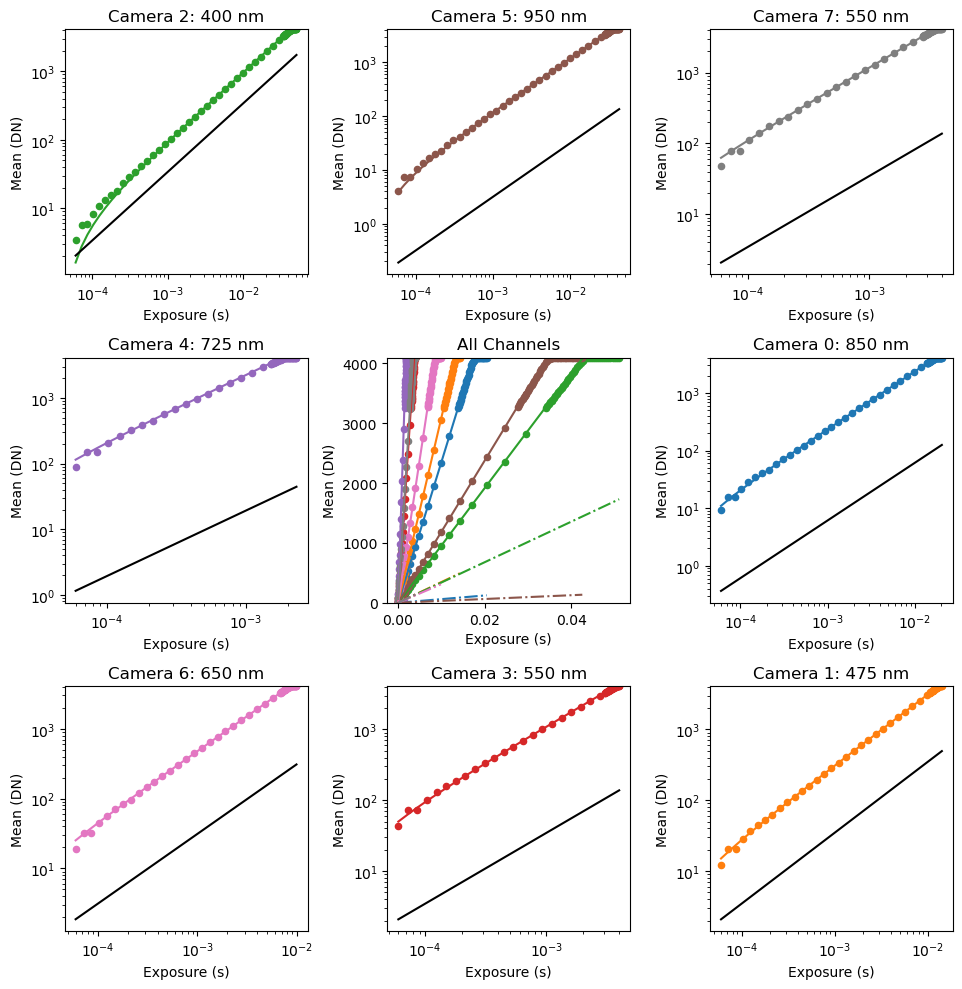

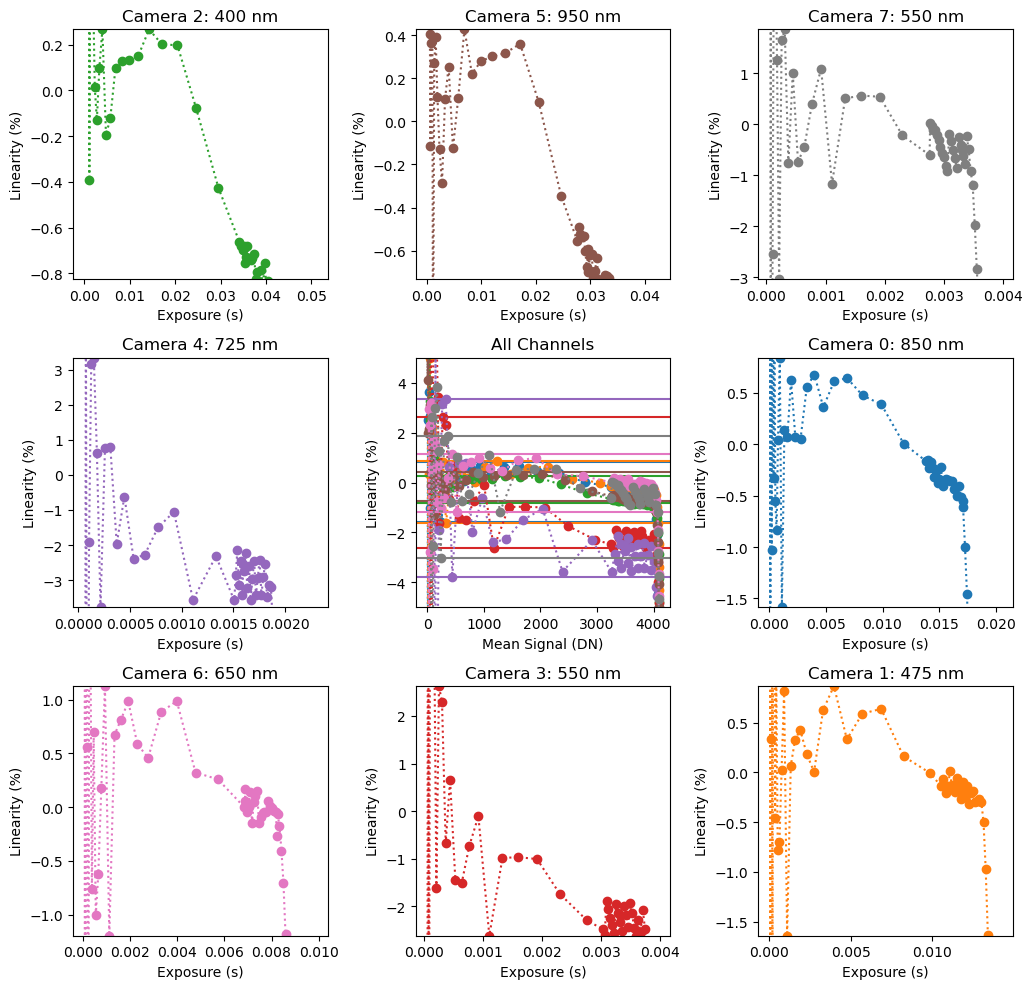

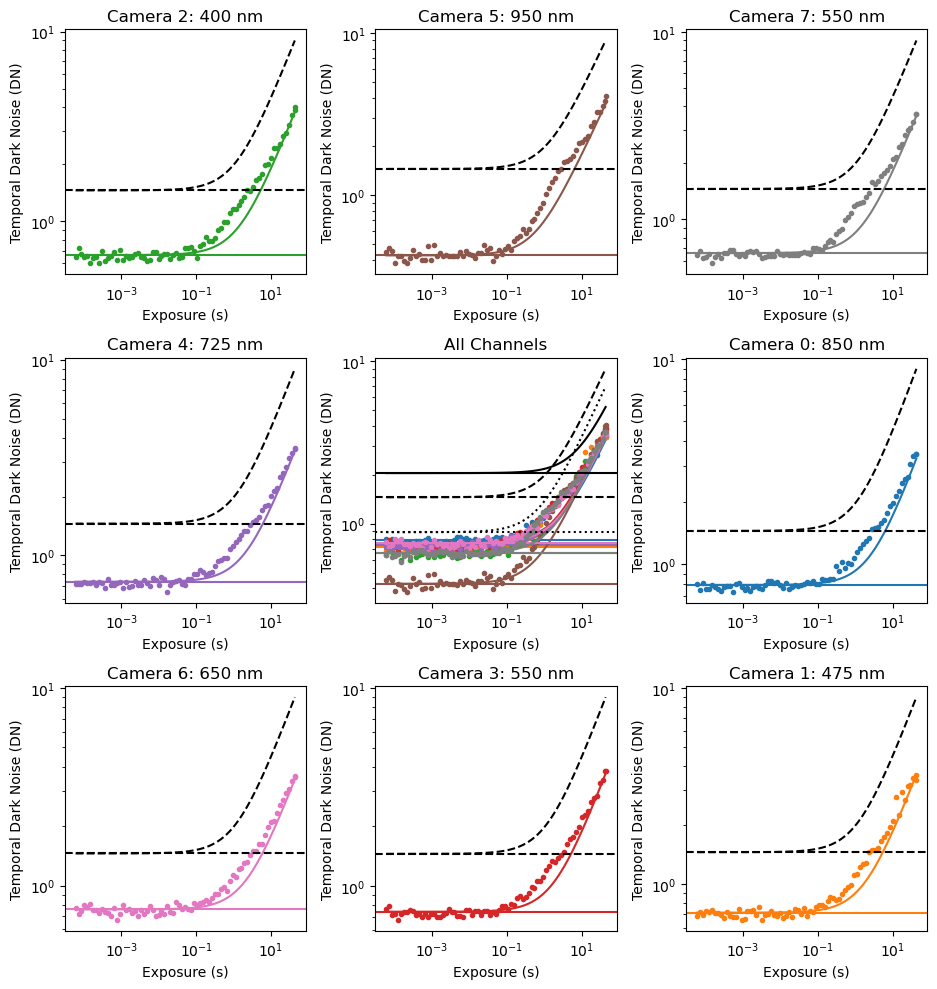

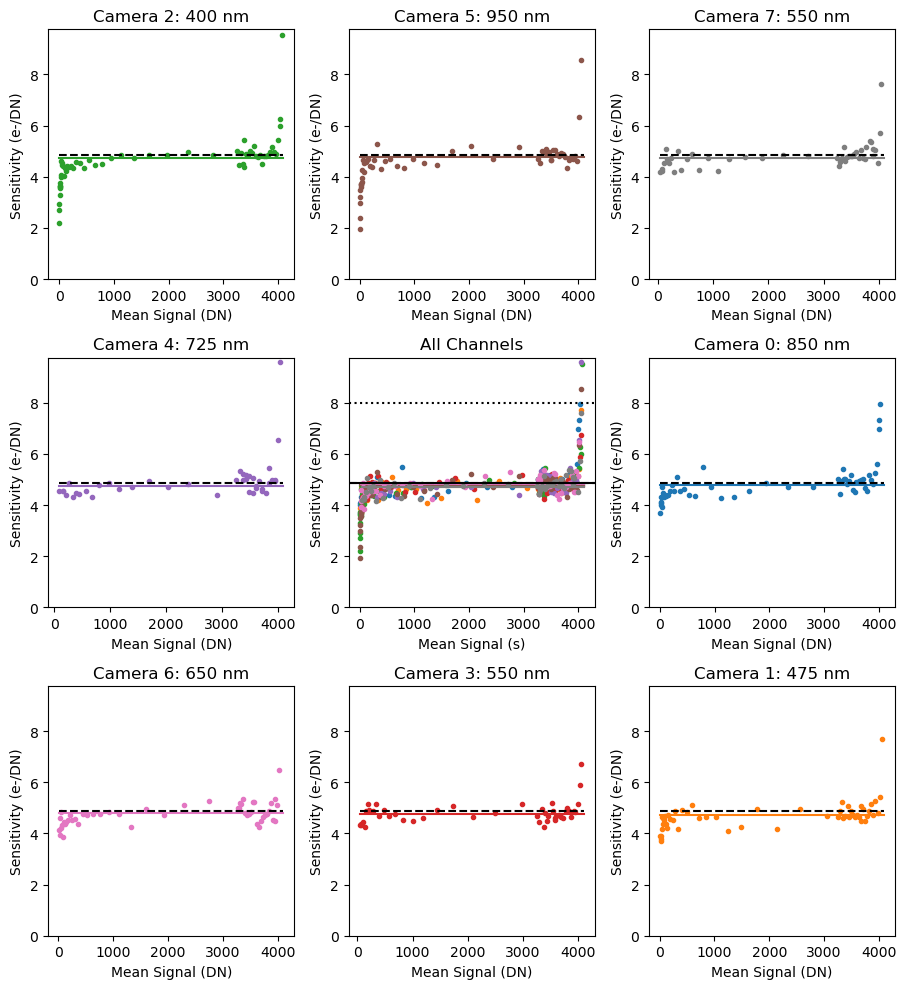

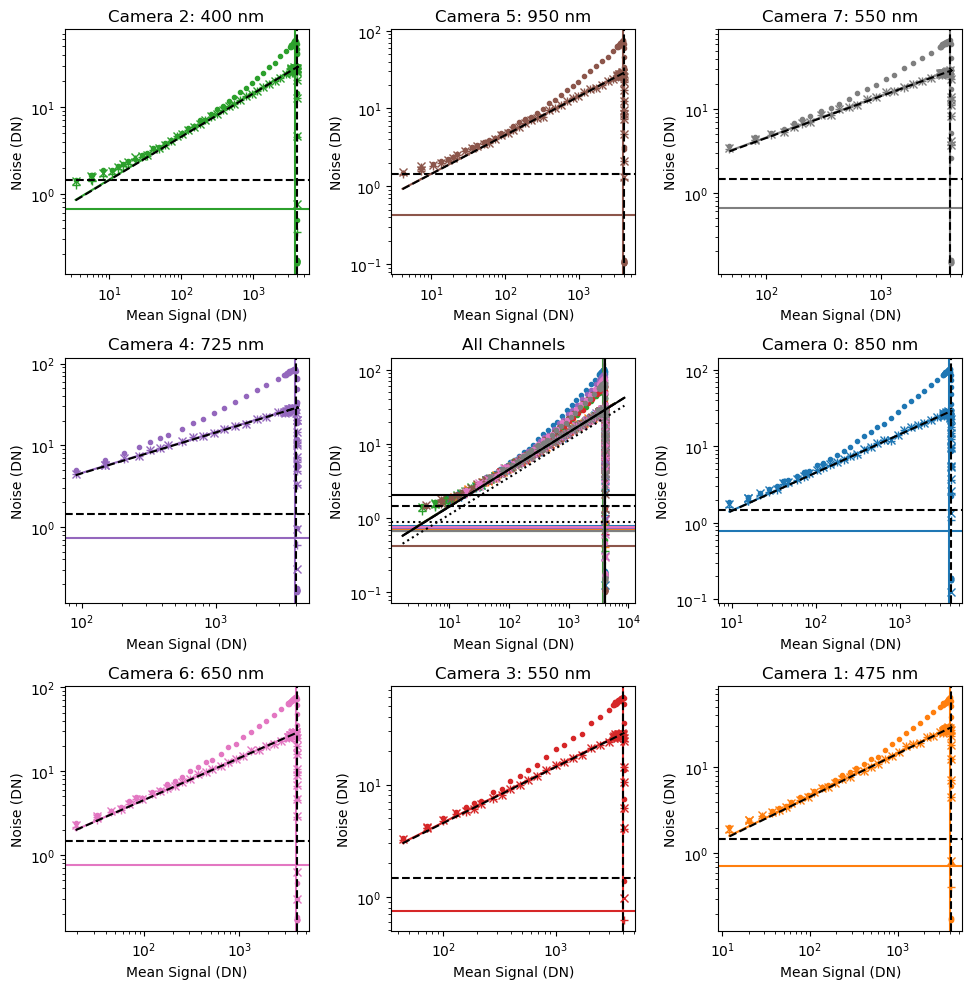

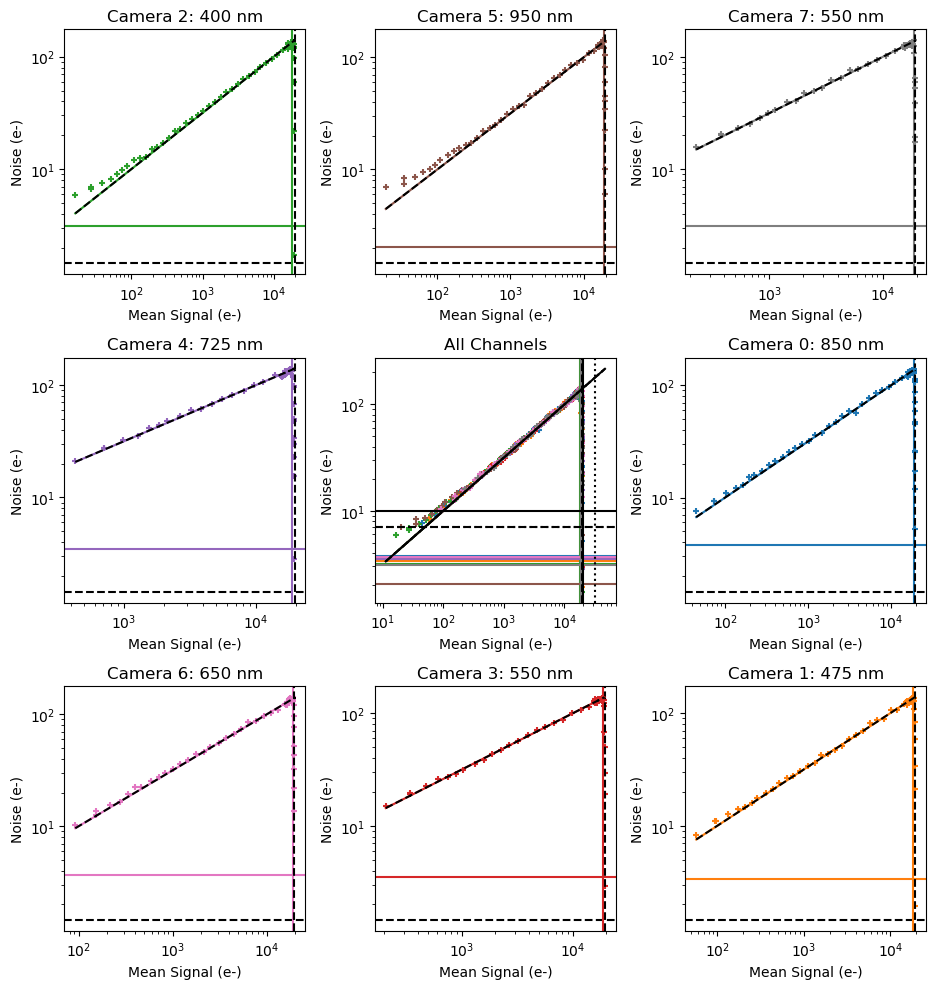

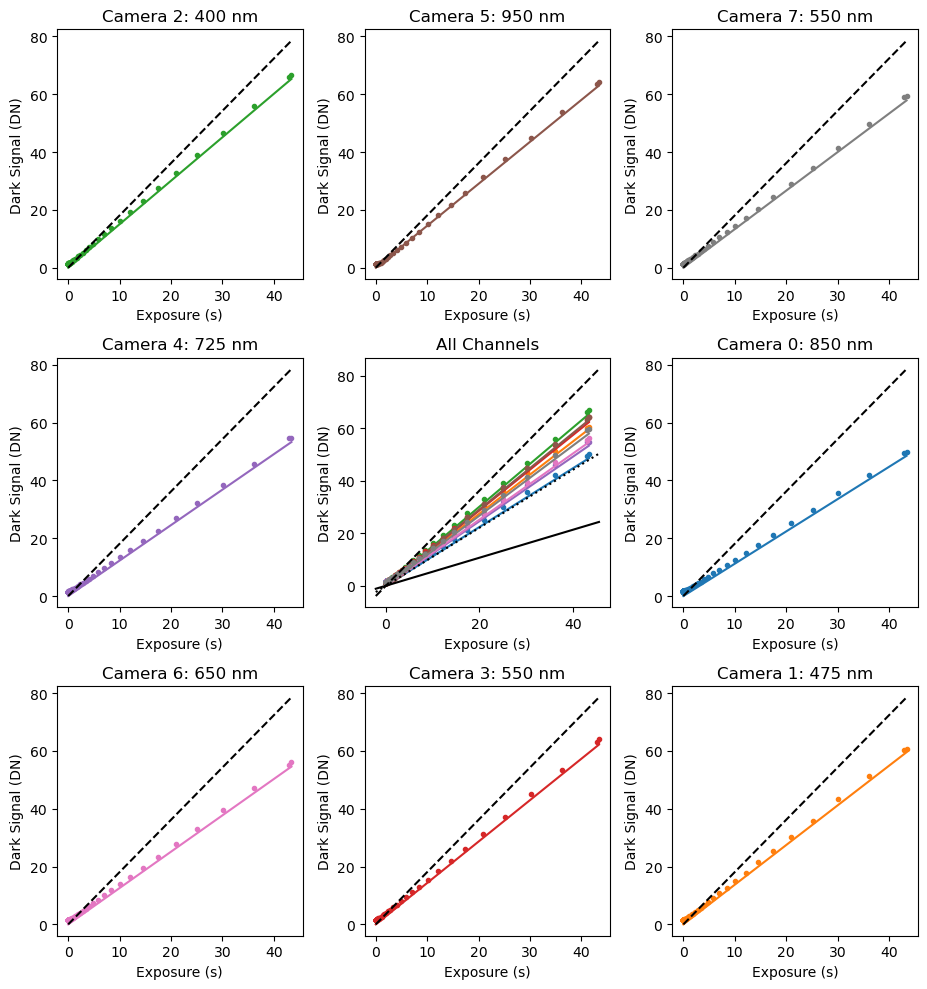

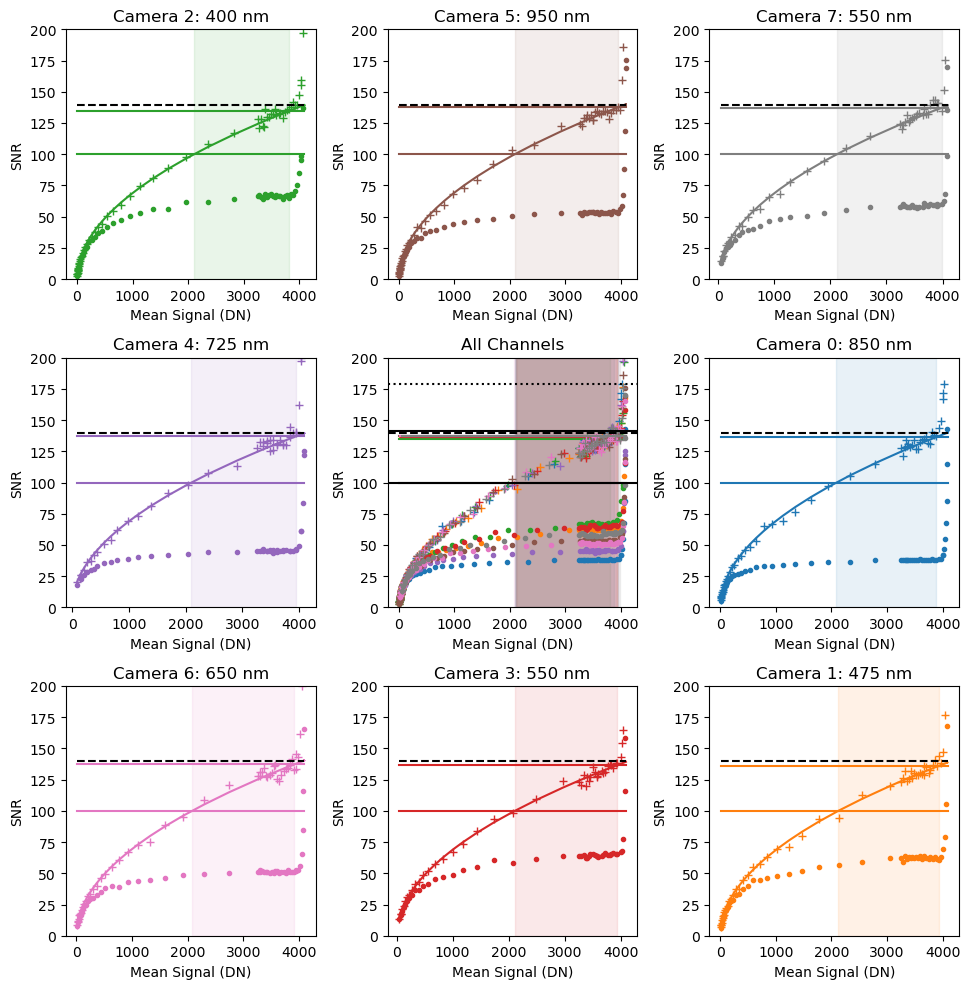

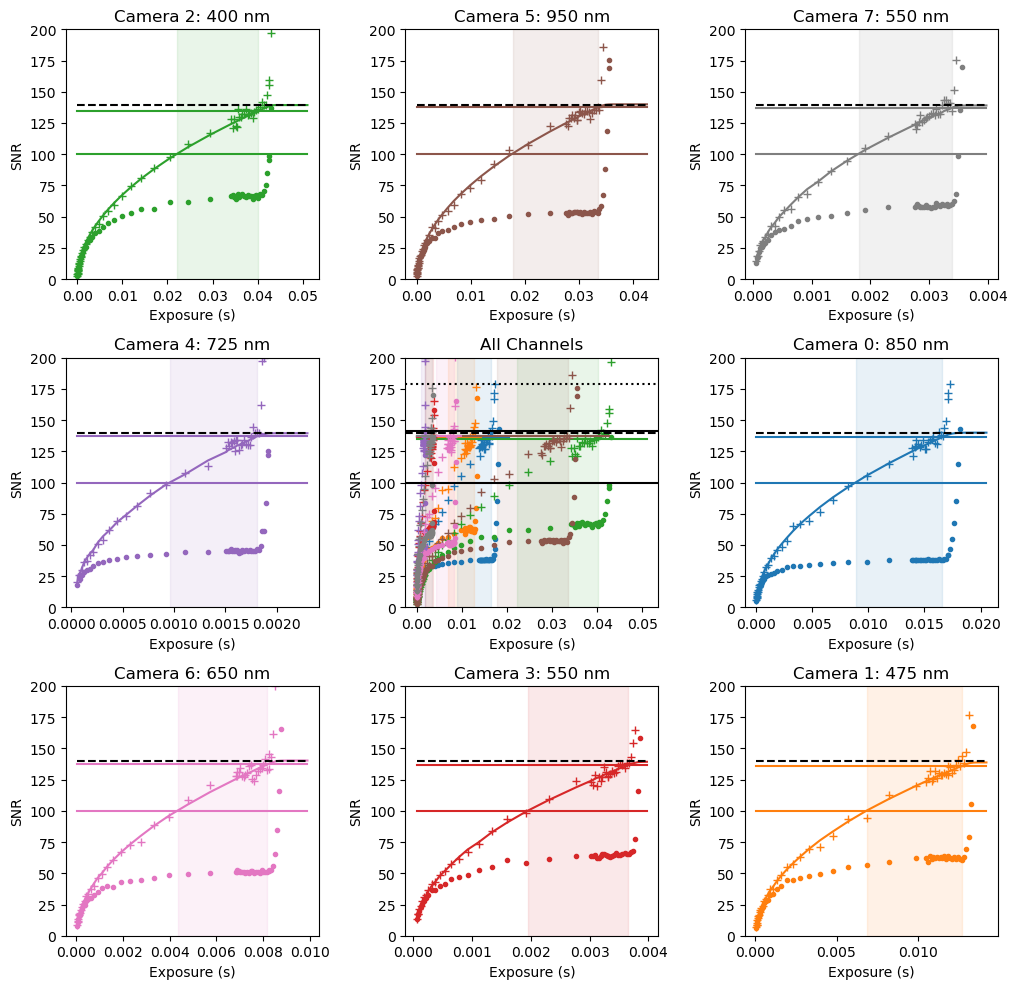

In [50]:
subject = 'SCT99_130623'
dark = 'dark_130623'
process_ptc(subject, dark)

--------------------------------------------
Processing SCT5_130623/0_850
Loaded images (850_10095570us_1_calibration) for: 0 (850 nm)
Loaded images (850_10095570us_2_calibration) for: 0 (850 nm)
Loaded images (850_104us_1_calibration) for: 0 (850 nm)
Loaded images (850_104us_2_calibration) for: 0 (850 nm)
Loaded images (850_105828us_1_calibration) for: 0 (850 nm)
Loaded images (850_105828us_2_calibration) for: 0 (850 nm)
Loaded images (850_1109us_1_calibration) for: 0 (850 nm)
Loaded images (850_1109us_2_calibration) for: 0 (850 nm)
Loaded images (850_1132285us_1_calibration) for: 0 (850 nm)
Loaded images (850_1132285us_2_calibration) for: 0 (850 nm)
Loaded images (850_11869us_1_calibration) for: 0 (850 nm)
Loaded images (850_11869us_2_calibration) for: 0 (850 nm)
Loaded images (850_12114684us_1_calibration) for: 0 (850 nm)
Loaded images (850_12114684us_2_calibration) for: 0 (850 nm)
Loaded images (850_124us_1_calibration) for: 0 (850 nm)
Loaded images (850_124us_2_calibration) for: 0

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT5_130623/1_475
Loaded images (475_10095570us_1_calibration) for: 1 (475 nm)
Loaded images (475_10095570us_2_calibration) for: 1 (475 nm)
Loaded images (475_104us_1_calibration) for: 1 (475 nm)
Loaded images (475_104us_2_calibration) for: 1 (475 nm)
Loaded images (475_105828us_1_calibration) for: 1 (475 nm)
Loaded images (475_105828us_2_calibration) for: 1 (475 nm)
Loaded images (475_1109us_1_calibration) for: 1 (475 nm)
Loaded images (475_1109us_2_calibration) for: 1 (475 nm)
Loaded images (475_1132285us_1_calibration) for: 1 (475 nm)
Loaded images (475_1132285us_2_calibration) for: 1 (475 nm)
Loaded images (475_11869us_1_calibration) for: 1 (475 nm)
Loaded images (475_11869us_2_calibration) for: 1 (475 nm)
Loaded images (475_12114684us_1_calibration) for: 1 (475 nm)
Loaded images (475_12114684us_2_calibration) for: 1 (475 nm)
Loaded images (475_124us_1_calibration) for: 1 (475 nm)
L

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT5_130623/2_400
Loaded images (400_10095570us_1_calibration) for: 2 (400 nm)
Loaded images (400_10095570us_2_calibration) for: 2 (400 nm)
Loaded images (400_104us_1_calibration) for: 2 (400 nm)
Loaded images (400_104us_2_calibration) for: 2 (400 nm)
Loaded images (400_105828us_1_calibration) for: 2 (400 nm)
Loaded images (400_105828us_2_calibration) for: 2 (400 nm)
Loaded images (400_1109us_1_calibration) for: 2 (400 nm)
Loaded images (400_1109us_2_calibration) for: 2 (400 nm)
Loaded images (400_1132285us_1_calibration) for: 2 (400 nm)
Loaded images (400_1132285us_2_calibration) for: 2 (400 nm)
Loaded images (400_11869us_1_calibration) for: 2 (400 nm)
Loaded images (400_11869us_2_calibration) for: 2 (400 nm)
Loaded images (400_12114684us_1_calibration) for: 2 (400 nm)
Loaded images (400_12114684us_2_calibration) for: 2 (400 nm)
Loaded images (400_124us_1_calibration) for: 2 (400 nm)
L

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT5_130623/3_550
Loaded images (550_10095570us_1_calibration) for: 3 (550 nm)
Loaded images (550_10095570us_2_calibration) for: 3 (550 nm)
Loaded images (550_104us_1_calibration) for: 3 (550 nm)
Loaded images (550_104us_2_calibration) for: 3 (550 nm)
Loaded images (550_105828us_1_calibration) for: 3 (550 nm)
Loaded images (550_105828us_2_calibration) for: 3 (550 nm)
Loaded images (550_1109us_1_calibration) for: 3 (550 nm)
Loaded images (550_1109us_2_calibration) for: 3 (550 nm)
Loaded images (550_1132285us_1_calibration) for: 3 (550 nm)
Loaded images (550_1132285us_2_calibration) for: 3 (550 nm)
Loaded images (550_11869us_1_calibration) for: 3 (550 nm)
Loaded images (550_11869us_2_calibration) for: 3 (550 nm)
Loaded images (550_12114684us_1_calibration) for: 3 (550 nm)
Loaded images (550_12114684us_2_calibration) for: 3 (550 nm)
Loaded images (550_124us_1_calibration) for: 3 (550 nm)
L

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT5_130623/4_725
Loaded images (725_10095570us_1_calibration) for: 4 (725 nm)
Loaded images (725_10095570us_2_calibration) for: 4 (725 nm)
Loaded images (725_104us_1_calibration) for: 4 (725 nm)
Loaded images (725_104us_2_calibration) for: 4 (725 nm)
Loaded images (725_105828us_1_calibration) for: 4 (725 nm)
Loaded images (725_105828us_2_calibration) for: 4 (725 nm)
Loaded images (725_1109us_1_calibration) for: 4 (725 nm)
Loaded images (725_1109us_2_calibration) for: 4 (725 nm)
Loaded images (725_1132285us_1_calibration) for: 4 (725 nm)
Loaded images (725_1132285us_2_calibration) for: 4 (725 nm)
Loaded images (725_11869us_1_calibration) for: 4 (725 nm)
Loaded images (725_11869us_2_calibration) for: 4 (725 nm)
Loaded images (725_12114684us_1_calibration) for: 4 (725 nm)
Loaded images (725_12114684us_2_calibration) for: 4 (725 nm)
Loaded images (725_124us_1_calibration) for: 4 (725 nm)
L

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT5_130623/5_950
Loaded images (950_10095570us_1_calibration) for: 5 (950 nm)
Loaded images (950_10095570us_2_calibration) for: 5 (950 nm)
Loaded images (950_104us_1_calibration) for: 5 (950 nm)
Loaded images (950_104us_2_calibration) for: 5 (950 nm)
Loaded images (950_105828us_1_calibration) for: 5 (950 nm)
Loaded images (950_105828us_2_calibration) for: 5 (950 nm)
Loaded images (950_1109us_1_calibration) for: 5 (950 nm)
Loaded images (950_1109us_2_calibration) for: 5 (950 nm)
Loaded images (950_1132285us_1_calibration) for: 5 (950 nm)
Loaded images (950_1132285us_2_calibration) for: 5 (950 nm)
Loaded images (950_11869us_1_calibration) for: 5 (950 nm)
Loaded images (950_11869us_2_calibration) for: 5 (950 nm)
Loaded images (950_12114684us_1_calibration) for: 5 (950 nm)
Loaded images (950_12114684us_2_calibration) for: 5 (950 nm)
Loaded images (950_124us_1_calibration) for: 5 (950 nm)
L

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT5_130623/6_650
Loaded images (650_10095570us_1_calibration) for: 6 (650 nm)
Loaded images (650_10095570us_2_calibration) for: 6 (650 nm)
Loaded images (650_104us_1_calibration) for: 6 (650 nm)
Loaded images (650_104us_2_calibration) for: 6 (650 nm)
Loaded images (650_105828us_1_calibration) for: 6 (650 nm)
Loaded images (650_105828us_2_calibration) for: 6 (650 nm)
Loaded images (650_1109us_1_calibration) for: 6 (650 nm)
Loaded images (650_1109us_2_calibration) for: 6 (650 nm)
Loaded images (650_1132285us_1_calibration) for: 6 (650 nm)
Loaded images (650_1132285us_2_calibration) for: 6 (650 nm)
Loaded images (650_11869us_1_calibration) for: 6 (650 nm)
Loaded images (650_11869us_2_calibration) for: 6 (650 nm)
Loaded images (650_12114684us_1_calibration) for: 6 (650 nm)
Loaded images (650_12114684us_2_calibration) for: 6 (650 nm)
Loaded images (650_124us_1_calibration) for: 6 (650 nm)
L

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
--------------------------------------------
Processing SCT5_130623/7_550
Loaded images (550_10095570us_1_calibration) for: 7 (550 nm)
Loaded images (550_10095570us_2_calibration) for: 7 (550 nm)
Loaded images (550_104us_1_calibration) for: 7 (550 nm)
Loaded images (550_104us_2_calibration) for: 7 (550 nm)
Loaded images (550_105828us_1_calibration) for: 7 (550 nm)
Loaded images (550_105828us_2_calibration) for: 7 (550 nm)
Loaded images (550_1109us_1_calibration) for: 7 (550 nm)
Loaded images (550_1109us_2_calibration) for: 7 (550 nm)
Loaded images (550_1132285us_1_calibration) for: 7 (550 nm)
Loaded images (550_1132285us_2_calibration) for: 7 (550 nm)
Loaded images (550_11869us_1_calibration) for: 7 (550 nm)
Loaded images (550_11869us_2_calibration) for: 7 (550 nm)
Loaded images (550_12114684us_1_calibration) for: 7 (550 nm)
Loaded images (550_12114684us_2_calibration) for: 7 (550 nm)
Loaded images (550_124us_1_calibration) for: 7 (550 nm)
L

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5182/2785243864.py:146: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_exp[num].set_ylim(0,2**12)


--------------------------------------------
141.4213562373095


,camera,k_adc,full_well,read_noise,dark_current,DR,lin_min,lin_max,t_exp_min,t_exp_max,expected_response,response
0,OROS-OTS,7.979000,32049.000000,7.070000,8.800000,73.127901,-0.410000,0.320000,0.000000,0.000000,0.000000,0.000000
1,OROS,4.863495,19535.048020,7.070000,8.800000,68.827901,-0.410000,0.320000,0.000000,0.000000,0.000000,0.000000
2,OROCHI,4.882812,20000.000000,10.000000,2.600000,66.020600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Camera 0: 850 nm,4.743554,17708.528698,3.757628,5.301134,73.465373,-0.793184,0.335695,0.162956,0.288572,6106.064279,13041.926994
4,Camera 1: 475 nm,4.741328,17578.080560,3.390148,6.505896,74.295055,-0.713053,0.232994,0.146923,0.258263,34660.711142,14465.206792
5,Camera 2: 400 nm,4.626564,16666.476764,3.066580,6.960136,74.703790,-0.685401,0.391864,0.494686,0.824468,33909.120210,4379.114367
6,Camera 3: 550 nm,4.719573,16718.786561,3.500105,6.763592,73.582474,-0.614549,0.325249,0.041289,0.069031,34660.683017,51542.150107
7,Camera 4: 725 nm,4.713707,17085.083571,3.461612,5.785081,73.866775,-0.519311,0.495324,0.018512,0.031627,19333.888021,114913.799557
8,Camera 5: 950 nm,4.654374,17391.624911,1.985535,6.757992,78.849251,-1.056234,0.113210,0.313386,0.545029,3166.538335,6932.808561
9,Camera 6: 650 nm,4.749194,17089.370079,3.597782,5.972066,73.533824,-0.853208,0.275671,0.086254,0.147402,31148.687877,24545.742224


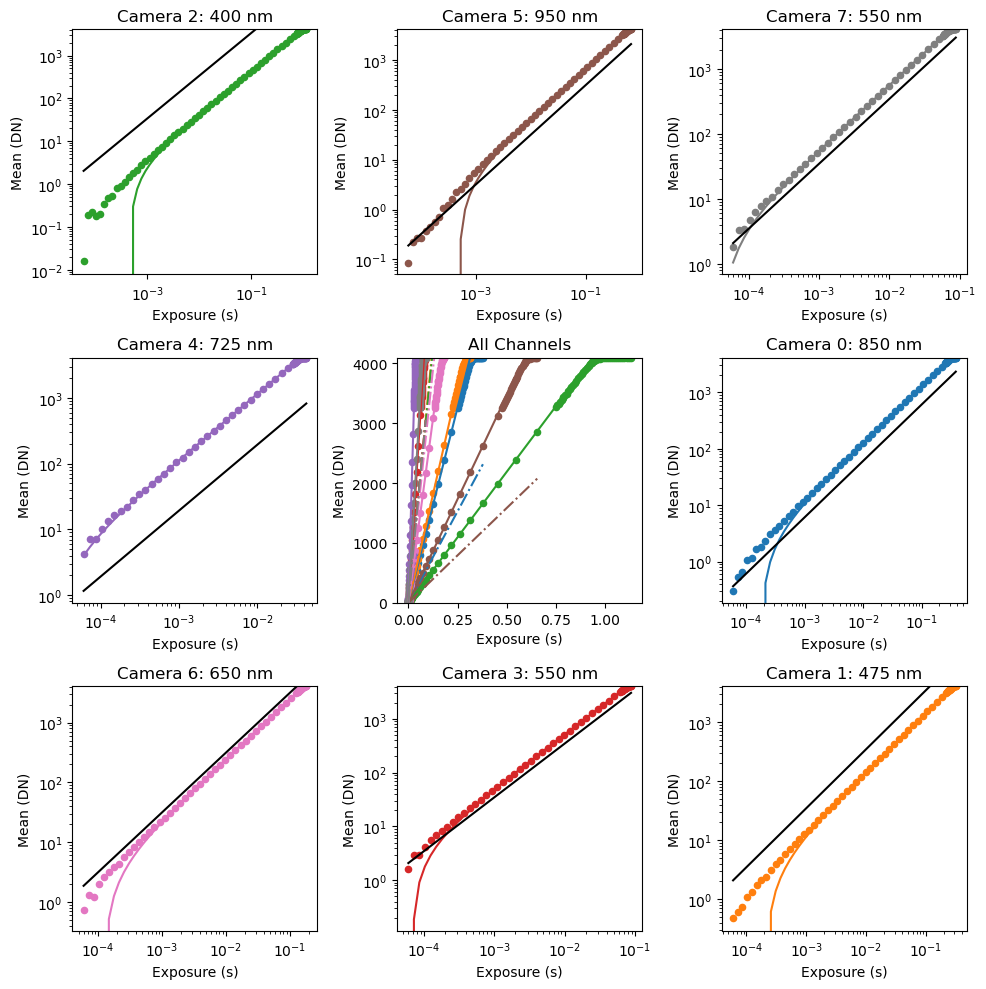

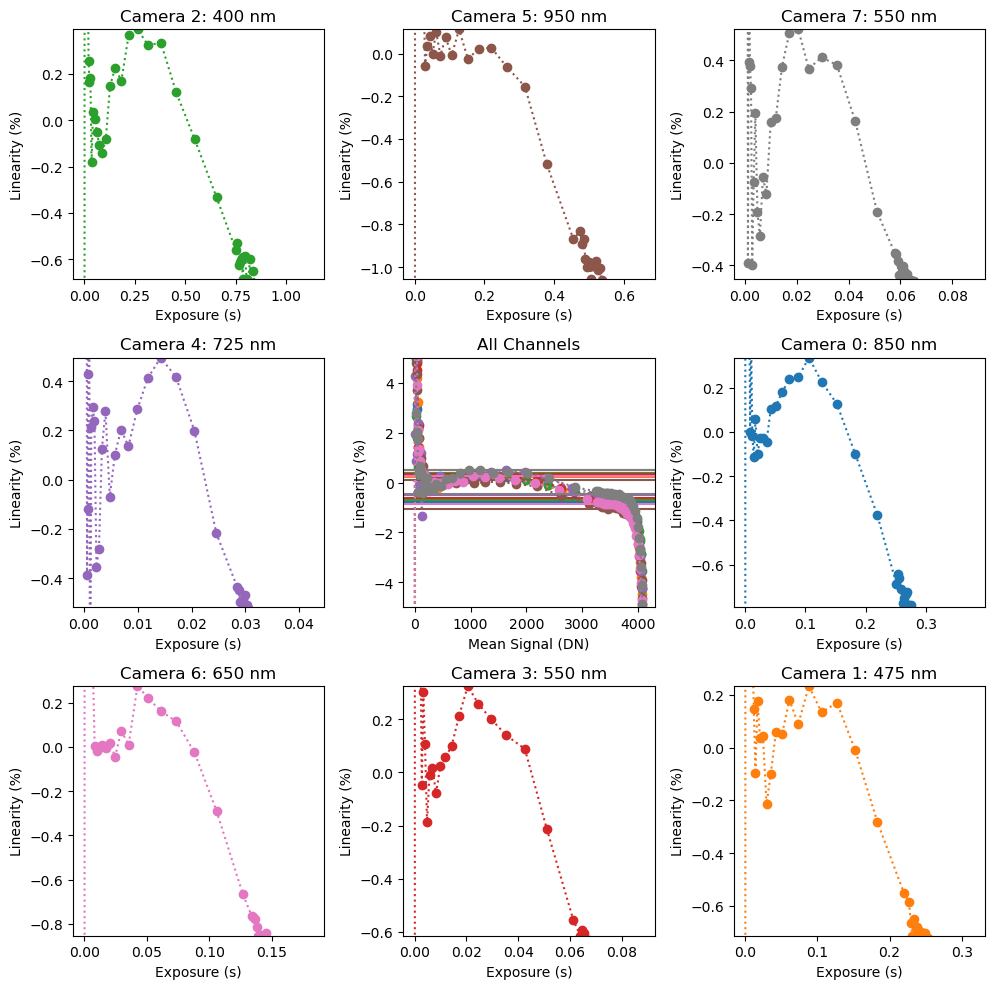

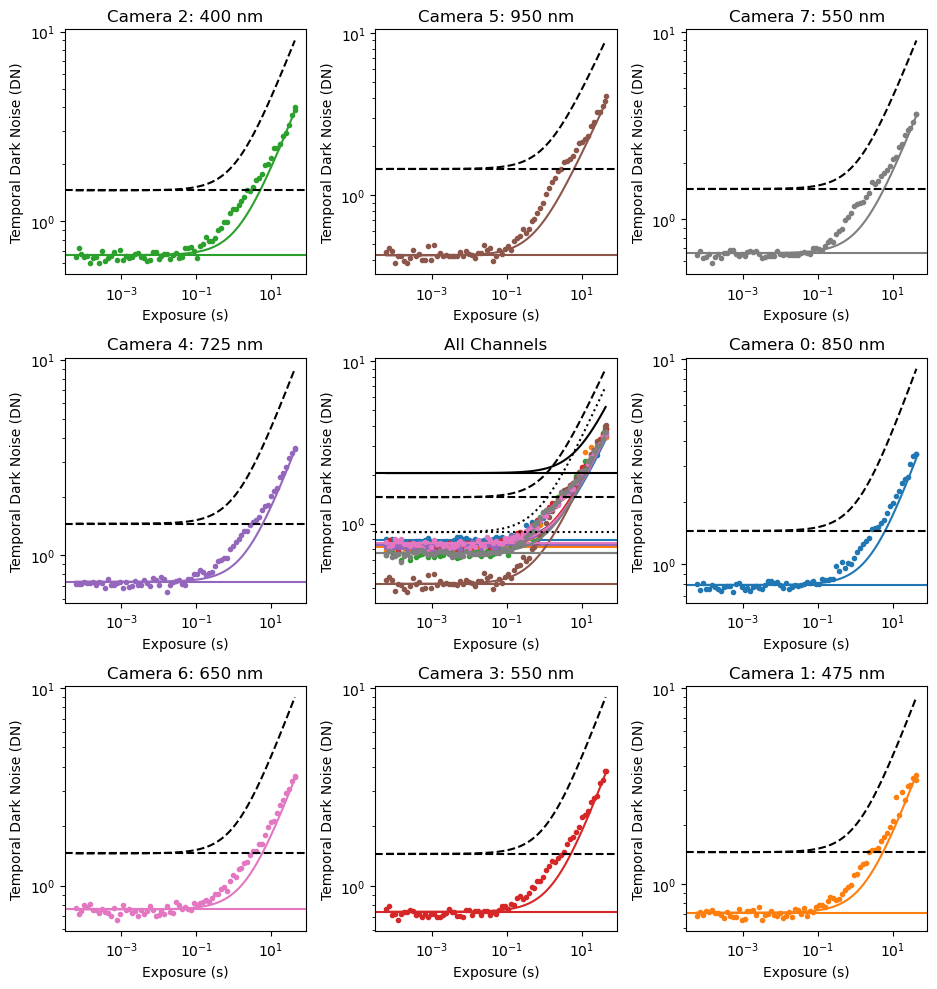

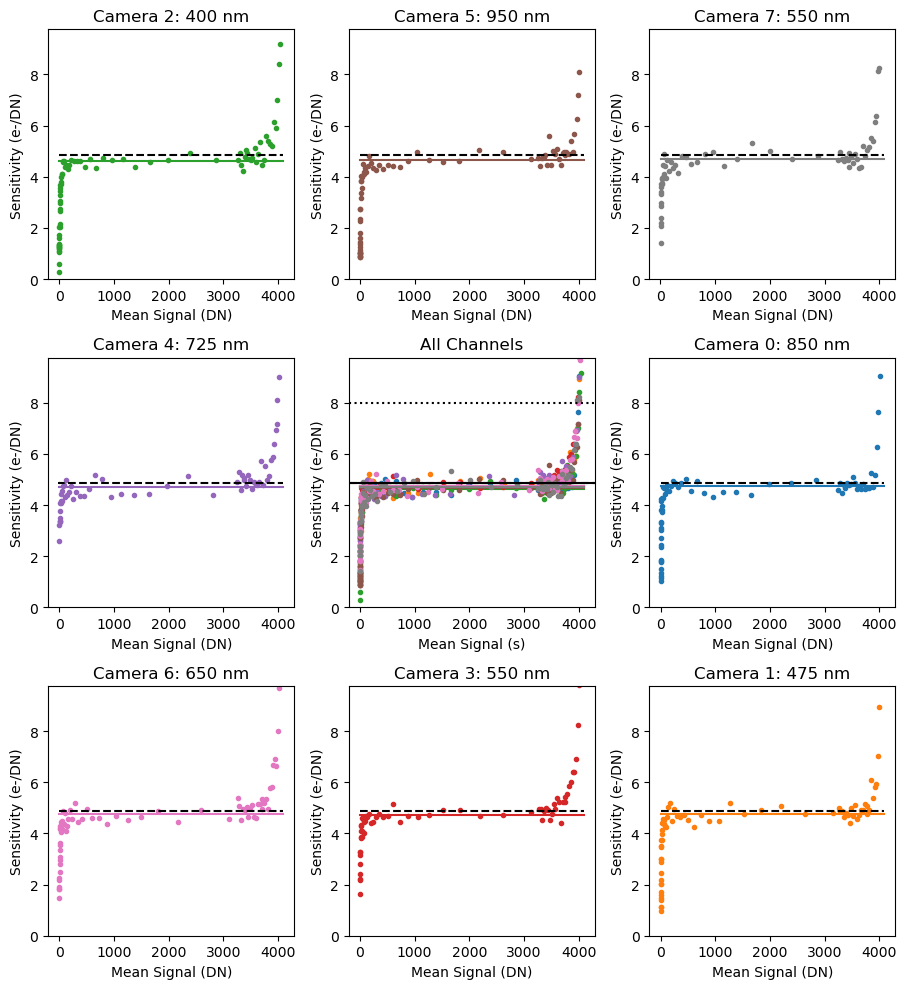

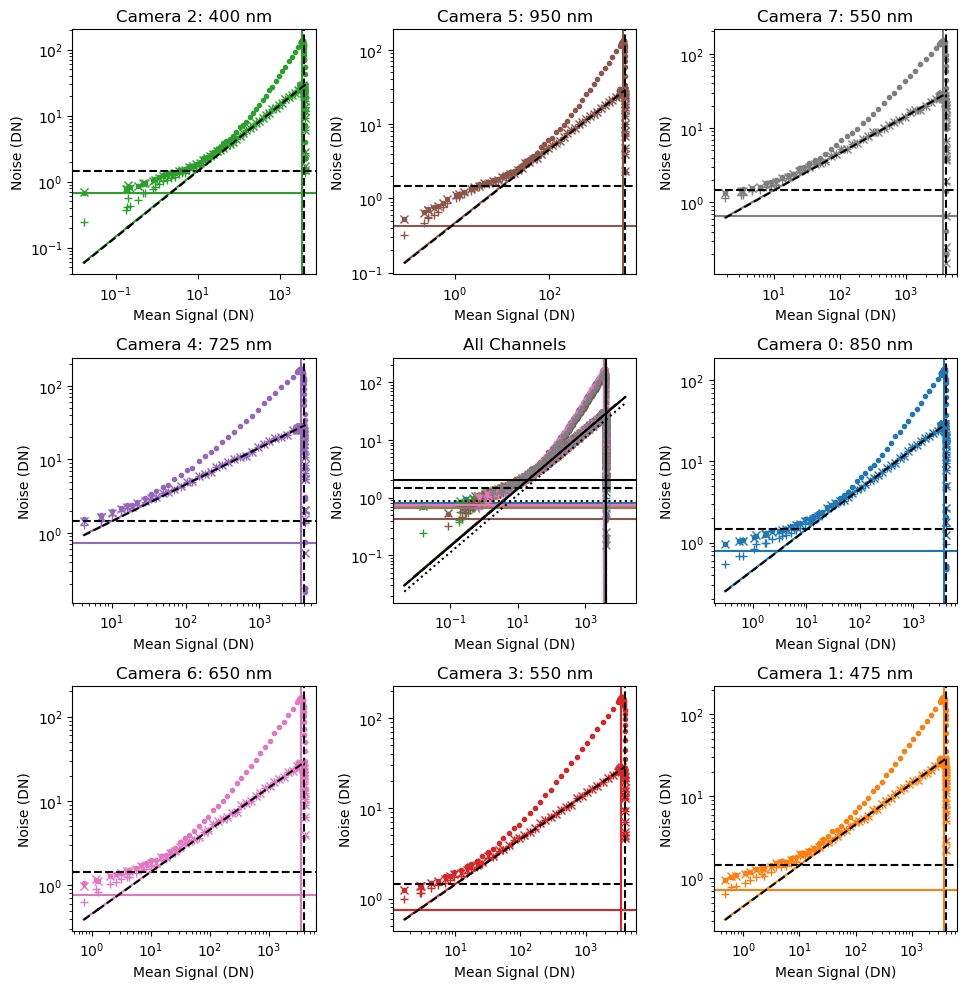

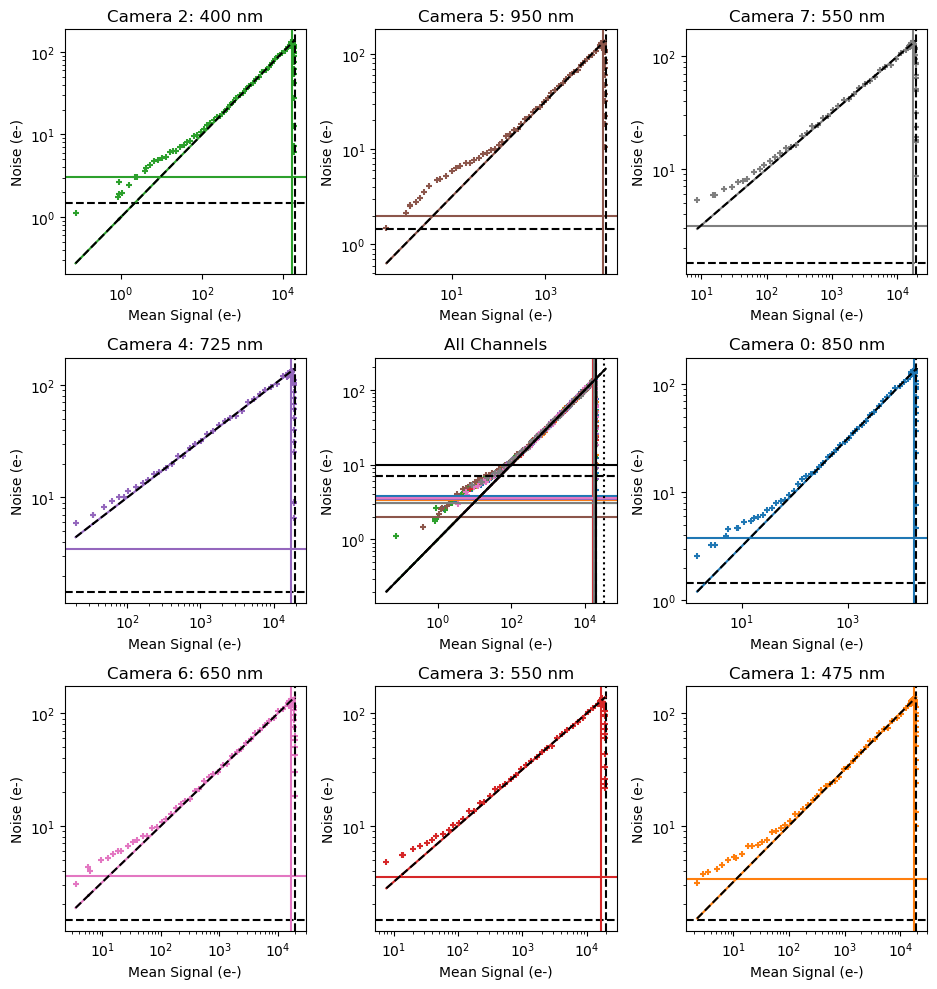

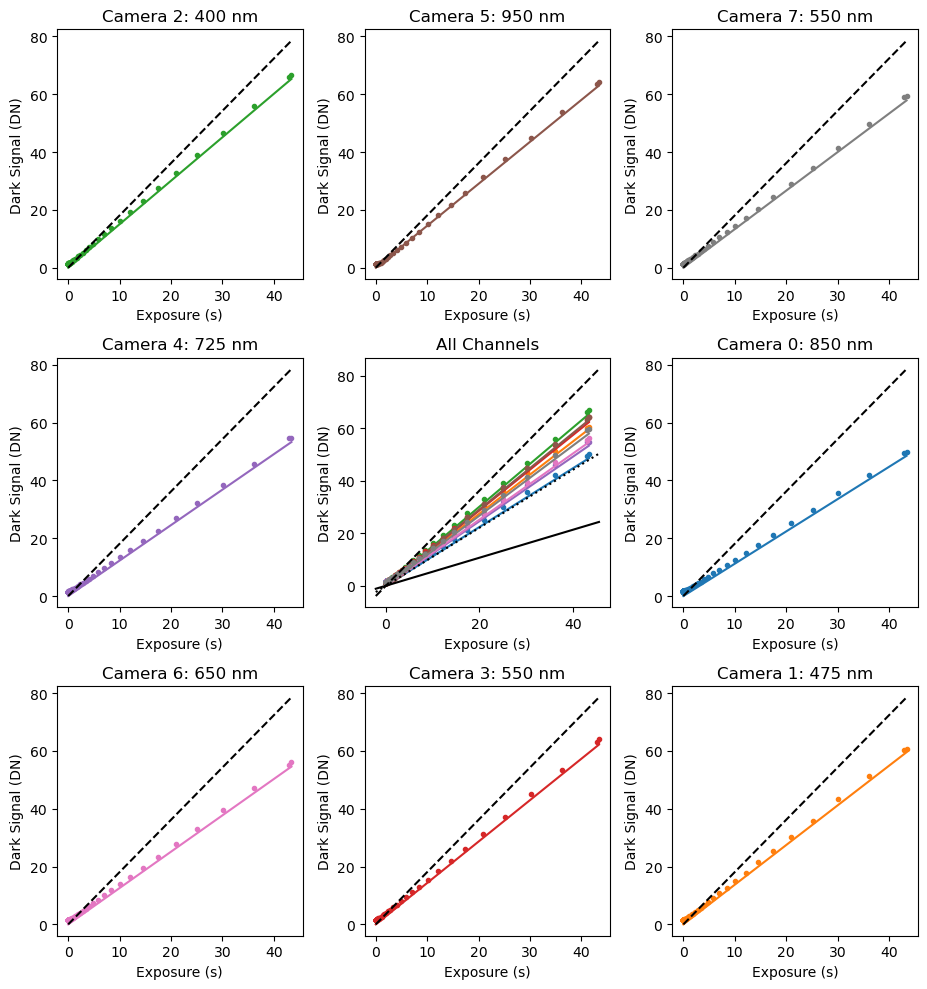

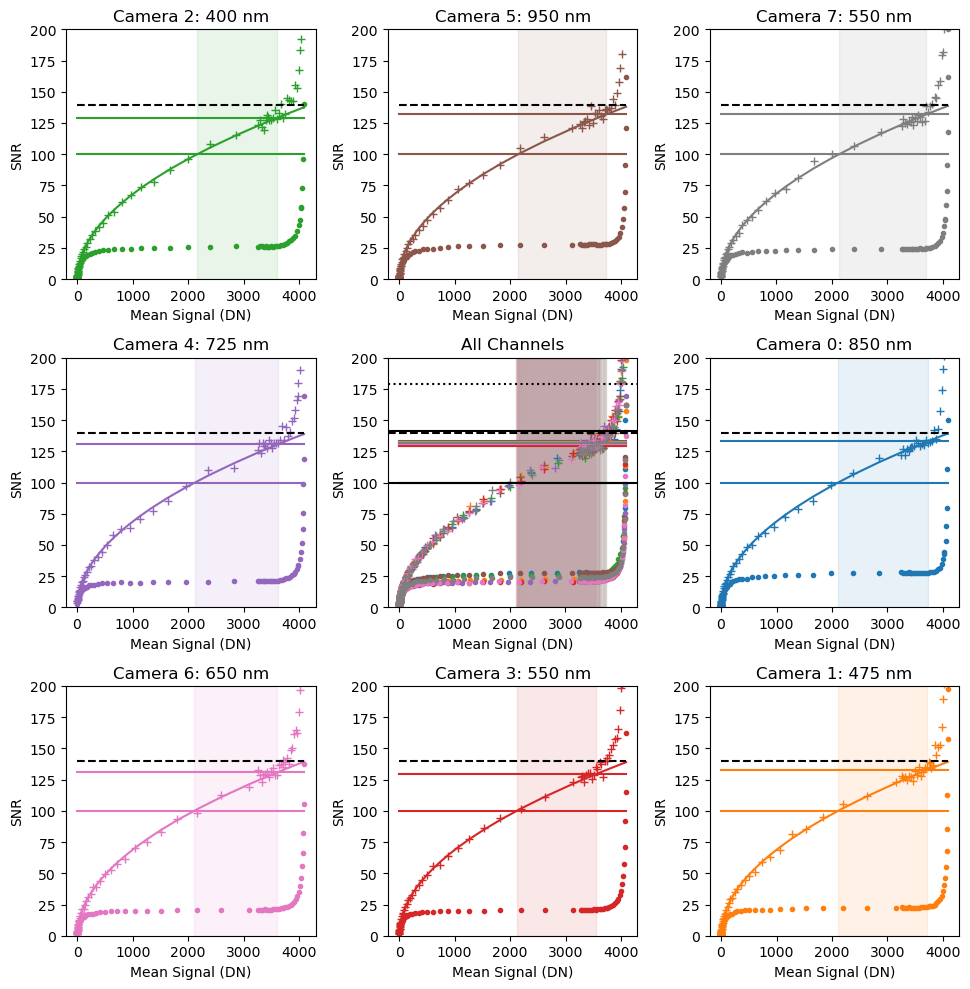

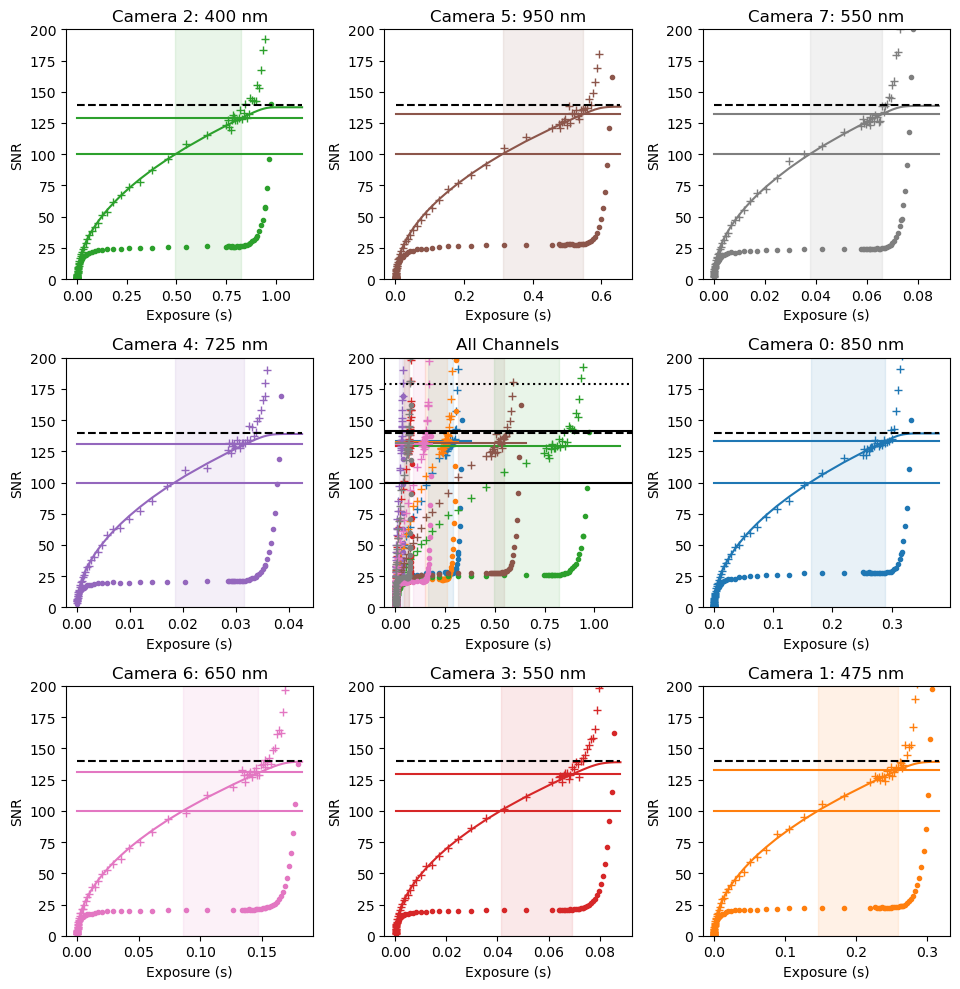

In [51]:
subject = 'SCT5_130623'
dark = 'dark_130623'
process_ptc(subject, dark)